# How robust is the pipeline upon testing?

In [1]:
import os
from subprocess import Popen, PIPE
import re
from rdkit import Chem
from rdkit.Chem import rdMolTransforms as rdmt
import pandas as pd
from tqdm import tqdm 
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import kendalltau
from sklearn.metrics import mean_squared_error
import numpy as np
from scipy.stats import pearsonr
import math
from scipy import stats
from scipy.stats import mannwhitneyu
from scipy.stats import ttest_ind
# Set up the working directory
cwd = os.getcwd()

# Dataset cleaning, adding neccesary columns etc etc...

### Loading in the datasets

In [2]:
# mpro_oe_water_original = pd.read_csv('results/mpro_oe/with_water/mpro_oe_w_water_data.csv')
# mpro_oe_water_recovered = pd.read_csv('results/mpro_oe/with_water/mpro_oe_w_water_data_errors.csv')
# mpro_oe_water_original_nonna = mpro_oe_water_original.dropna(subset=['computed_dG'])
# # Combine the datasets and remove duplicates based on 'ligand_name', keeping only rows with valid computed_dG values
# combined_df = pd.concat([mpro_oe_water_recovered, mpro_oe_water_original_nonna])
# unique_combined_df = combined_df.drop_duplicates(subset='ligand_name')
# # unique_combined_df.to_csv('results/mpro_oe/with_water/mpro_oe_w_water_data_combined_unique_rows.csv', index=False)

In [3]:
# full dataset
# loading LeakyPDB dataset
leakypdb = pd.read_csv('leakypdb.csv')
leakypdb.rename(columns={'Unnamed: 0': 'pdb_id',
                          'header': 'protein_family', 
                          'seq':'protein_sequence',
                          'kd/ki':'binding_affinity',
                          'value':'pkd/pki'}, inplace=True)
leakypdb['pdb_id'] = leakypdb['pdb_id'].str.upper()

# loading leakypdb exp results dataset
leakypdb_test_vina_water = pd.read_csv('results/leakypdb_test_vina/with_water/leakypdb_test_vina_w_water_data.csv')
leakypdb_test_vina = pd.read_csv('results/leakypdb_test_vina/without_water/leakypdb_test_vina_wo_water_data.csv')
leakypdb_test_vina_v1 = pd.read_csv('results/leakypdb_test_vina/without_water_v1/leakypdb_test_vina_data.csv')
leakypdb_test_oe_water = pd.read_csv('results/leakypdb_test_OE/with_water/leakypdb_test_OE_w_water_data.csv')
leakypdb_test_oe = pd.read_csv('results/leakypdb_test_OE/without_water/leakypdb_test_OE_data.csv')
mpro_vina_water = pd.read_csv('results/mpro_vina/with_water/mpro_vina_w_water_data.csv')
mpro_oe_water_v1 = pd.read_csv('results/mpro_oe/with_water/mpro_oe_w_water_data_cleaned_unique_rows.csv')
mpro_oe_water = pd.read_csv('results/mpro_oe/with_water/mpro_oe_w_water_data_combined_unique_rows.csv')
# mpro_oe_water_recovered = pd.read_csv('results/mpro_oe/with_water/mpro_oe_w_water_data_errors.csv')
mpro_ligands = pd.read_csv('results/mpro_vina/Updated_Mpro_data.csv')

In [4]:
casp16_autotaxin_oe = pd.read_csv('results/CASP16/Autotaxin_metal/CASP16_autotaxin_metal_oe_docking_data_cleaned.csv')
casp16_autotaxin_vina = pd.read_csv('results/CASP16/Autotaxin_metal/CASP16_autotaxin_metal_vina_docking_data_cleaned.csv')
casp16_cathepsin_oe = pd.read_csv('results/CASP16/Cathepsin_G/CASP16_cathepsin_G_oe_docking_data.csv')
casp16_cathepsin_vina = pd.read_csv('results/CASP16/Cathepsin_G/CASP16_cathepsin_G_vina_docking_data.csv')
casp16_chymase_oe = pd.read_csv('results/CASP16/Chymase/CASP16_chymase_oe_docking_data.csv')
casp16_chymase_vina = pd.read_csv('results/CASP16/Chymase/CASP16_chymase_vina_docking_data.csv')
casp16_mpro_dimer_oe = pd.read_csv('results/CASP16/Mpro_dimer_2/CASP16_mpro_dimer_oe_docking_data_cleaned.csv')
casp16_mpro_dimer_vina = pd.read_csv('results/CASP16/Mpro_dimer_2/CASP16_mpro_dimer_vina_docking_data_cleaned.csv')
casp16_mpro_monomer_oe = pd.read_csv('results/CASP16/Mpro_monomer/CASP16_mpro_oe_docking_data_cleaned.csv')
casp16_mpro_monomer_vina = pd.read_csv('results/CASP16/Mpro_monomer/CASP16_mpro_vina_docking_data_cleaned.csv')

## Processing leakypdb - vina data, adding some necessary columns etc

In [5]:
def add_leakypdb_data(df, leakypdb_df):
    '''add leakypdb data to vina dataframe'''

    pdb_ids = []
    for id in df['ligand_name']:
        pdb_ids.append(id.split('_')[0].upper())

    df['pdb_id'] = pdb_ids

    # Filter the DataFrame for the specific PDB ID
    filtered_df = leakypdb_df[leakypdb_df['pdb_id'].isin(pdb_ids)] 

    # Check if the specific columns exist in the DataFrame
    required_columns = ['pdb_id','smiles', 'protein_sequence', 'binding_affinity']
    missing_columns = [col for col in required_columns if col not in leakypdb_df.columns]
    if missing_columns:
        print( f"Missing columns in the data: {', '.join(missing_columns)}")
    # Extract the needed information
    result = filtered_df[required_columns]
    # append result to the vina_df dataframe
    df = pd.merge(df, result, on='pdb_id')

    # leakypdb_test_vina_water.to_csv('leakypdb_test_vina_w_water_data_cleaned.csv', index=False)
    return df

In [6]:
leakypdb_test_vina_water = add_leakypdb_data(leakypdb_test_vina_water, leakypdb)
leakypdb_test_oe_water = add_leakypdb_data(leakypdb_test_oe_water, leakypdb)
leakypdb_test_vina = add_leakypdb_data(leakypdb_test_vina, leakypdb)

## Next, we remove redundant rows of data for OE

In [7]:
def oe_remove_duplicate_data(oe_df):
    ''' This function takes in a dataframe oe_df, sorts it based on specific columns, removes duplicate rows, concatenates the unique rows with NaN rows, sorts the final dataframe, and returns the cleaned dataframe.'''

    # First, sort the dataframe by 'ligand_name', 'protein_name', and 'computed_dG' to ensure the lowest values come first
    # if ligand_name is present, sort by ligand_name, protein_name, and computed_dG
    if {'ligand_name', 'protein_name'}.issubset(oe_df.columns):
        try:
            df_sorted = oe_df.sort_values(by=['ligand_name', 'protein_name', 'computed_dG'])
        except:
            df_sorted = oe_df.sort_values(by=['ligand_name', 'protein_name', 'Chemgauss4'])
    else:
        # if ligand_name is not present, sort by pdb_id and computed_dG
        df_sorted = oe_df.sort_values(by=['pdb_id', 'computed_dG'])

    # Separate the rows where 'computed_dG' is NaN
    nan_rows = df_sorted[df_sorted['computed_dG'].isna()]

    # Drop NaN rows from the sorted dataframe to process only valid dG values
    valid_rows = df_sorted.dropna(subset=['computed_dG'])

    # Drop duplicates, keeping the first occurrence which has the lowest 'computed_dG' due to sorting
    if {'ligand_name', 'protein_name'}.issubset(oe_df.columns):
        unique_rows = valid_rows.drop_duplicates(subset=['ligand_name', 'protein_name'], keep='first')
    else: 
        unique_rows = valid_rows.drop_duplicates(subset=['pdb_id'], keep='first')

    # Concatenate the unique rows with the NaN rows
    final_df = pd.concat([unique_rows, nan_rows])

    # Optionally, sort final dataframe by index or any other column if needed
    final_df = final_df.sort_index()

    # Save or display the final dataframe
    # final_df.to_csv('leakypdb_test_OE_w_water_data_cleaned_unique_rows.csv', index=False)
    return final_df

In [8]:
leakypdb_test_oe_water = oe_remove_duplicate_data(leakypdb_test_oe_water)
leakypdb_test_oe = oe_remove_duplicate_data(leakypdb_test_oe)
mpro_oe_water = oe_remove_duplicate_data(mpro_oe_water)
# mpro_oe_water_recovered = oe_remove_duplicate_data(mpro_oe_water_recovered)

### Cleaning up the Mpro datasets

In [9]:
def mpro_add_info(df, df_ligands):
    '''add mpro ligands data to vina dataframe'''

    # Extract the numeric part of the 'ligand_name' for sorting
    df['ligand_number'] = df['ligand_name'].str.extract(r'Updated_Mpro_data_(\d+)').astype(int)

    # Sort the DataFrame by the extracted numeric part
    df_sorted = df.sort_values(by='ligand_number').drop(columns='ligand_number')

    df_sorted['ligand_number'] = df_sorted['ligand_name'].str.extract(r'Updated_Mpro_data_(\d+)').astype(int)

    # Merge the DataFrames
    df_sorted = df_sorted.set_index('ligand_number')
    df_ligands = df_ligands.reset_index().rename(columns={'index': 'ligand_number'})
    df_merged = df_sorted.merge(df_ligands, on='ligand_number')
    # renaming columns
    df_merged = df_merged.rename(columns={'Drug': 'ligand_smiles'})
    df_merged = df_merged.rename(columns={'Y': 'binding_affinity'})
    df_merged = df_merged.rename(columns={'Target': 'protein_sequence'})
    # reordering the columns
    df_merged = df_merged.drop(columns='ligand_number')
    df_merged = df_merged[['ligand_name', 'ligand_smiles', 'protein_name', 'protein_sequence', 'computed_dG','error_message','binding_affinity']]
    # df_merged.to_csv('results/mpro_vina/with_water/mpro_vina_w_water_data_cleaned.csv', index=False)
    return df_merged

In [10]:
mpro_vina_water = mpro_add_info(mpro_vina_water, mpro_ligands)
mpro_oe_water = mpro_add_info(mpro_oe_water, mpro_ligands)
# mpro_oe_water_recovered = mpro_add_info(mpro_oe_water_recovered, mpro_ligands)


mpro_vina_water = oe_remove_duplicate_data(mpro_vina_water)
mpro_oe_water = oe_remove_duplicate_data(mpro_oe_water)
# mpro_oe_water_recovered = oe_remove_duplicate_data(mpro_oe_water_recovered)

In [11]:
def calculate_pipeline_error_rate(df, column_name, method_name):
    """
    Calculate and print the error rate for a given method based on non-null values in the specified column.

    Parameters:
    - df (pd.DataFrame): The DataFrame containing the data.
    - column_name (str): The name of the column with error messages.
    - method_name (str): The name of the method or software for which the error rate is being calculated.
    """
    error_count = df[column_name].notna().sum()
    error_rate = error_count / len(df)
    print(f'Error rate for {method_name}: {error_rate:.2%}')  # Display as a percentage


In [12]:
# Example usage
calculate_pipeline_error_rate(leakypdb_test_oe_water, 'error_message', 'OpenEye with water')
calculate_pipeline_error_rate(leakypdb_test_oe, 'error_message', 'OpenEye without water')
calculate_pipeline_error_rate(leakypdb_test_vina_water, 'error_message', 'AutoDock Vina with water')
calculate_pipeline_error_rate(leakypdb_test_vina, 'error_message', 'AutoDock Vina without water')
calculate_pipeline_error_rate(leakypdb_test_vina_v1, 'error_message', 'AutoDock Vina without water, version 1')
calculate_pipeline_error_rate(mpro_vina_water, 'error_message', 'AutoDock Vina with water, Mpro')
# calculate_pipeline_error_rate(mpro_oe_water_recovered, 'error_message', 'OpenEye with water (recovered), Mpro')
calculate_pipeline_error_rate(mpro_oe_water, 'error_message', 'OpenEye with water, Mpro')

Error rate for OpenEye with water: 2.44%
Error rate for OpenEye without water: 2.44%
Error rate for AutoDock Vina with water: 3.09%
Error rate for AutoDock Vina without water: 2.54%
Error rate for AutoDock Vina without water, version 1: 35.61%
Error rate for AutoDock Vina with water, Mpro: 0.51%
Error rate for OpenEye with water, Mpro: 1.24%


# Pre-process and clean the collected dataset, so that we can plot them

## Vina

In [13]:
# correct the binding affinity values to be float, and in unit M, currently they are in either uM or nM
def convert_unit_M(x):
    if x.endswith('fM'):
        return float(x[:-2]) * 1e-15
    if x.endswith('pM'):
        return float(x[:-2]) * 1e-12
    if x.endswith('nM'):
        return float(x[:-2]) * 1e-9
    if x.endswith('uM'):
        return float(x[:-2]) * 1e-6
    if x.endswith('mM'):
        return float(x[:-2]) * 1e-3
    if x.endswith('M'):
        return float(x)

def ki_to_delta_g(ki, temperature=298):
    R = 1.987e-03  # kcal/(mol*K), this is correct for cal to kcal conversion
    dG = R * temperature * math.log(ki)
    return dG

import numpy as np

def pIC50_to_dG(pIC50, temperature=298.15):
    """
    Convert pIC50 to IC50 and then to Gibbs free energy change (ΔG) in kcal/mol.
    
    Parameters:
    - pIC50: float, the pIC50 value
    - temperature: float, the temperature in Kelvin (default is 298.15 K)
    
    Returns:
    - IC50: float, the IC50 value in Molar
    - dG_kcal_mol: float, the Gibbs free energy change in kcal/mol
    """
    # Constants
    R = 8.314  # J/(mol·K) - universal gas constant
    J_to_kcal = 4184  # Conversion factor from Joules to kilocalories

    # Step 1: Convert pIC50 to IC50
    IC50 = 10**(-pIC50)
    
    # Step 2: Convert IC50 to ΔG in Joules
    dG_Jmol = R * temperature * np.log(IC50)
    
    # Step 3: Convert ΔG from Joules to kcal
    dG_kcal_mol = dG_Jmol / J_to_kcal
    
    return dG_kcal_mol

def preprocess_data(df, db=leakypdb):
    '''
    This function preprocesses the data by converting the binding affinity values to float according to their units, then creates a new column for the experimental dG values, and finally removes any zero values in the computed dG column.'''
    # extract only valid values from the computed_dG column
    df = df[df['computed_dG'].notna()]

    try:
        # add a column corresponding to the pkd/pki column in leakypdb, which has the right labels for each pdb id
        df['pkd/pki'] = db[db['pdb_id'].isin(df['pdb_id'].to_list())]['pkd/pki'].to_list()
    except:
        # Create a mapping of pdb_id to pkd/pki
        pkd_pki_mapping = db.set_index('pdb_id')['pkd/pki'].to_dict()
        
        # Map the pkd/pki values to the DataFrame
        df['pkd/pki'] = df['pdb_id'].map(pkd_pki_mapping)

    # Drop rows where pkd/pki is NaN (no match found in db)
    df = df.dropna(subset=['pkd/pki'])
    
    # correct the binding affinity values to be float, they are currently in the form of strings e.g., Kd=0.006uM or Ki=0.0001nM
    df['binding_affinity'] = df['binding_affinity'].str.replace('Ki[=~><]|Kd[=~><]|IC50[=~><]', '', regex=True) # remove the Kd= and Ki= from the string
    
    df['binding_affinity'] = df['binding_affinity'].apply(convert_unit_M)
    
    df['experimental_dG'] = df['binding_affinity'].apply(ki_to_delta_g)
    
    # get rid of any zero value in the computed dG column
    out_df = df[df['computed_dG'] != 0]
    
    return out_df

def preprocess_mpro_data(df):
    '''This function preprocesses the mpro data by getting rid of 0 values and na values from the computed_dG column, and then get rid of the _0 suffix in oe ligand_name.'''
    try:
        df = df[df['computed_dG'] != 0]
        df = df[df['computed_dG'].notna()]
    except:
        df = df[df['Chemgauss4'] != 0]
        df = df[df['Chemgauss4'].notna()] 
        
    df['experimental_dG'] = df['binding_affinity'].apply(pIC50_to_dG) # binding_affinity here is in fact pIC50
    
    # get rid of the _0 in the ligand_name column
    df['ligand_name'] = df['ligand_name'].str.replace(r'(_0)$', '',regex=True)
    
    return df

def preprocess_casp16_data(df):
    '''This function preprocesses the casp16 data by getting rid of 0 values and na values from the computed_dG column'''
    try:
        df = df[df['computed_dG'] != 0]
        df = df[df['computed_dG'].notna()]
    except:
        df = df[df['Chemgauss4'] != 0]
        df = df[df['Chemgauss4'].notna()] 
        
    df['ligand_name'] = df['ligand_name'].str.replace(r'(_\d)(.*)(_0)$', r'\1\2', regex=True)
    
    return df

In [14]:
leakypdb_test_vina = preprocess_data(leakypdb_test_vina)
leakypdb_test_vina_water = preprocess_data(leakypdb_test_vina_water)
leakypdb_test_oe_water = preprocess_data(leakypdb_test_oe_water, leakypdb)
leakypdb_test_oe_water.rename(columns={'computed_dG': 'Chemgauss4'}, inplace=True)
leakypdb_test_oe = preprocess_data(leakypdb_test_oe, leakypdb)
leakypdb_test_oe.rename(columns={'computed_dG': 'Chemgauss4'}, inplace=True)
mpro_vina_water = preprocess_mpro_data(mpro_vina_water)
mpro_oe_water = preprocess_mpro_data(mpro_oe_water)
mpro_oe_water.rename(columns={'computed_dG': 'Chemgauss4'}, inplace=True)
# mpro_oe_water_recovered = preprocess_mpro_data(mpro_oe_water_recovered)
# mpro_oe_water_recovered.rename(columns={'computed_dG': 'Chemgauss4'}, inplace=True)


casp16_autotaxin_oe = preprocess_casp16_data(casp16_autotaxin_oe)
casp16_autotaxin_vina = preprocess_casp16_data(casp16_autotaxin_vina)
casp16_cathepsin_oe = preprocess_casp16_data(casp16_cathepsin_oe)
casp16_cathepsin_vina = preprocess_casp16_data(casp16_cathepsin_vina)
casp16_chymase_oe = preprocess_casp16_data(casp16_chymase_oe)
casp16_chymase_vina = preprocess_casp16_data(casp16_chymase_vina)
casp16_mpro_dimer_oe = preprocess_casp16_data(casp16_mpro_dimer_oe)
casp16_mpro_dimer_vina = preprocess_casp16_data(casp16_mpro_dimer_vina)
casp16_mpro_monomer_vina = preprocess_casp16_data(casp16_mpro_monomer_vina)
casp16_mpro_monomer_oe = preprocess_casp16_data(casp16_mpro_monomer_oe)

/tmp/ipykernel_3653244/3051303579.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pkd/pki'] = db[db['pdb_id'].isin(df['pdb_id'].to_list())]['pkd/pki'].to_list()
/tmp/ipykernel_3653244/3051303579.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pkd/pki'] = db[db['pdb_id'].isin(df['pdb_id'].to_list())]['pkd/pki'].to_list()
/tmp/ipykernel_3653244/3051303579.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer]

In [15]:
# dont know what this is -.-...
# # Group by 'ligand_smiles' and get the index of the row with the minimum 'Chemgauss4' score for each group
# idx_ligand_smiles = leakypdb_test_oe_water.groupby('smiles')['computed_dG'].idxmin()

# # Select the rows with these indices
# leakypdb_test_oe_water = leakypdb_test_oe_water.loc[idx_ligand_smiles]

# # Optionally reset the index
# leakypdb_test_oe_water.reset_index(drop=True, inplace=True)
# leakypdb_test_oe_water.rename(columns={'computed_dG': 'Chemgauss4'}, inplace=True)
# # leakypdb_test_OpenEye.to_csv('leakypdb_test_OpenEye_data_cleaned.csv', index=False)
# leakypdb_test_oe_water

In [16]:
# # export all the cleaned data
# leakypdb_test_vina_water.to_csv('results/leakypdb_test_vina/with_water/leakypdb_test_vina_w_water_data_prepped4plot.csv', index=False)
# leakypdb_test_vina.to_csv('results/leakypdb_test_vina/without_water/leakypdb_test_vina__data_prepped4plot.csv', index=False)
# leakypdb_test_vina_v1.to_csv('results/leakypdb_test_vina/without_water_v1/leakypdb_test_vina__data_prepped4plot.csv', index=False)
# leakypdb_test_oe_water.to_csv('results/leakypdb_test_OE/with_water/leakypdb_test_OE_w_water_data_prepped4plot.csv', index=False)
# leakypdb_test_oe.to_csv('results/leakypdb_test_OE/without_water/leakypdb_test_OE_data_prepped4plot.csv', index=False)
# mpro_vina_water.to_csv('results/mpro_vina/with_water/mpro_vina_w_water_data_prepped4plot.csv', index=False)
# mpro_oe_water.to_csv('results/mpro_oe/with_water/mpro_oe_w_water_data_prepped4plot.csv', index=False)

# Defining some equations for calculating stats and plotting

In [17]:
# mean absolute error MAE
def compute_mean_absolute_error(actual_values, predicted_values):
    '''Compute the Mean Absolute Error (MAE) between the actual and predicted values.'''
    mae = np.mean(np.abs(actual_values - predicted_values))
    return mae

# compute kendall tau
def compute_kendall_tau(X, Y):
    '''Compute the Kendall's Tau correlation coefficient between two lists.'''
    tau, _ = kendalltau(X, Y)
    return tau

def compute_RMSE(actual_values, predicted_values):
    '''Compute the Root Mean Squared Error (RMSE) between the actual and predicted values.'''
    rmse = np.sqrt(mean_squared_error(actual_values, predicted_values))
    return rmse

def compute_pearson_correlation(actual_values, predicted_values):
    '''Compute the Pearson correlation coefficient between the actual and predicted values.'''
    pearson_correlation, _ = pearsonr(actual_values, predicted_values)
    return pearson_correlation

# spearman rank correlation
def compute_spearman_rank_correlation(actual_values, predicted_values):
    '''Compute the Spearman Rank correlation coefficient between the actual and predicted values.'''
    spearman_rank_correlation, _ = stats.spearmanr(actual_values, predicted_values)
    return spearman_rank_correlation

from sklearn.metrics import r2_score
# not used
def compute_r2(actual_values, predicted_values):
    '''Compute the R² (coefficient of determination) between the actual and predicted values.'''
    r2 = r2_score(actual_values, predicted_values)
    return r2


In [20]:
def generate_report(df1, df2):
    '''Generate a report for the computed dG values to compare between vina and OE.'''
    if 'computed_dG' in df1.columns:
        # df1.rename(columns={'computed_dG': 'Vina'}, inplace=True)
        # compute mean absolute error for dG
        mean_absolute_error_dG = compute_mean_absolute_error(df2['experimental_dG'], df1['computed_dG'])
        # compute kendal tau for dG
        kendal_tau_dG = compute_kendall_tau(df2['experimental_dG'], df1['computed_dG'])
        # compute pearson correlation for dG
        pearson_correlation_dG = compute_pearson_correlation(df2['experimental_dG'], df1['computed_dG'])
        # compute RMSE for dG
        rmse_dG = compute_RMSE(df2['experimental_dG'], df1['computed_dG'])
        # spearman rank correlation
        spearman_rank_correlation_dG = compute_spearman_rank_correlation(df2['experimental_dG'], df1['computed_dG'])
        # r2
        # r2 = compute_r2(df2['experimental_dG'], df1['computed_dG'])
    elif 'Chemgauss4' in df1.columns:
        # compute mean absolute error for dG
        mean_absolute_error_dG = compute_mean_absolute_error(df2['experimental_dG'], df1['Chemgauss4'])
        # compute kendal tau for dG
        kendal_tau_dG = compute_kendall_tau(df2['experimental_dG'], df1['Chemgauss4'])
        # compute pearson correlation for dG
        pearson_correlation_dG = compute_pearson_correlation(df2['experimental_dG'], df1['Chemgauss4'])
        # compute RMSE for dG
        rmse_dG = compute_RMSE(df2['experimental_dG'], df1['Chemgauss4'])
        # spearman rank correlation
        spearman_rank_correlation_dG = compute_spearman_rank_correlation(df2['experimental_dG'], df1['Chemgauss4'])
        # r2
        # r2 = compute_r2(df2['experimental_dG'], df1['Chemgauss4'])
    else: 
        raise ValueError('The column name for the computed dG values is not correct.')
    
    print(f'Mean Absolute Error for dG: {mean_absolute_error_dG:.2f}')
    print(f'Kendall Tau for dG: {kendal_tau_dG:.2f}')
    print(f'Pearson Correlation for dG: {pearson_correlation_dG:.2f}')
    print(f'RMSE for dG: {rmse_dG:.2f}')
    print(f'Spearman Rank Correlation for dG: {spearman_rank_correlation_dG:.2f}')
    # print(f'R²: {r2:.2f}')

In [21]:
generate_report(leakypdb_test_vina, leakypdb_test_vina)

Mean Absolute Error for dG: 2.05
Kendall Tau for dG: 0.29
Pearson Correlation for dG: 0.44
RMSE for dG: 2.57
Spearman Rank Correlation for dG: 0.42


In [27]:
def plot_scatter(X, Y, nameX, nameY, min_X= -18, max_X=0):
    '''Plot the scatter plot for computed vs experimental dG and save the plot.'''
    rmse = compute_RMSE(X, Y)
    pearson_correlation = compute_pearson_correlation(X, Y)
    R_2 = pearson_correlation ** 2
    kendall_tau = compute_kendall_tau(X, Y)
    mae = compute_mean_absolute_error(X, Y)
    spearman_rank_correlation = compute_spearman_rank_correlation(X, Y)
    
    # Plot the scatter plot for dG values of 2 software and save the plot
    plt.figure(figsize=(8, 8))
    plt.scatter(X, Y, color='#1B8EF2')
    # plot an x=y line

    plt.plot([min_X, max_X], [min_X, max_X], color='#F2A516')
    # Plot lines showing RMSE deviation
    plt.plot([min_X, max_X], [min_X + 1, max_X + 1], linestyle='--', color='#F2A516')
    plt.plot([min_X, max_X], [min_X - 1, max_X - 1], linestyle='--', color='#F2A516')
    # Fill the region between the RMSE lines and the X=Y line
    plt.fill_between([min_X, max_X], [min_X + 1, max_X + 1], [min_X - 1, max_X - 1], color='#F2A516', alpha=0.3)


    # Add the RMSE value to the plot
    plt.text(0.05, 0.95, f"RMSE = {rmse:.2f}", ha='left', va='top', transform=plt.gca().transAxes)
    # Add the R2 value to the plot
    plt.text(0.05, 0.925, f"R\u00b2 = {R_2:.2f}", ha='left', va='top', transform=plt.gca().transAxes)
    # Add the Pearson correlation value to the plot
    plt.text(0.05, 0.90, f"Pearson = {pearson_correlation:.2f}", ha='left', va='top', transform=plt.gca().transAxes)
    # Add the Kendall Tau value to the plot
    plt.text(0.05, 0.875, f"Kendall\'s Tau = {kendall_tau:.2f}", ha='left', va='top', transform=plt.gca().transAxes)
    # Add the MAE value to the plot
    plt.text(0.05, 0.85, f"MAE = {mae:.2f}", ha='left', va='top', transform=plt.gca().transAxes)
    # Add the Spearman Rank correlation value to the plot
    plt.text(0.05, 0.825, f"Spearman Rank = {spearman_rank_correlation:.2f}", ha='left', va='top', transform=plt.gca().transAxes)

    plt.xlabel(f'{nameX}')
    plt.ylabel(f'{nameY}')
    plt.title(f'{nameX} vs {nameY}')
    plt.axis('equal')
    plt.xlim(min_X, max_X)
    plt.ylim(min_X, max_X)
        
    # Replace unallowed characters in nameX and nameY for filename
    nameX = nameX.replace(' ', '_').replace('/', '_').replace('(', '').replace(')', '').replace(':', '-').replace(',', '')
    nameY = nameY.replace(' ', '_').replace('/', '_').replace('(', '').replace(')', '').replace(':', '-').replace(',', '')

    plt.savefig(f'figures/{nameX}_{nameY}.png')
    plt.show()

#     /* Color Theme Swatches in Hex */
# .Beautiful-colorful-cityscape-1-hex { color: #1B8EF2; }
# .Beautiful-colorful-cityscape-2-hex { color: #1BA0F2; }
# .Beautiful-colorful-cityscape-3-hex { color: #38BDF2; }
# .Beautiful-colorful-cityscape-4-hex { color: #38D0F2; }
# .Beautiful-colorful-cityscape-5-hex { color: #F2A516; }

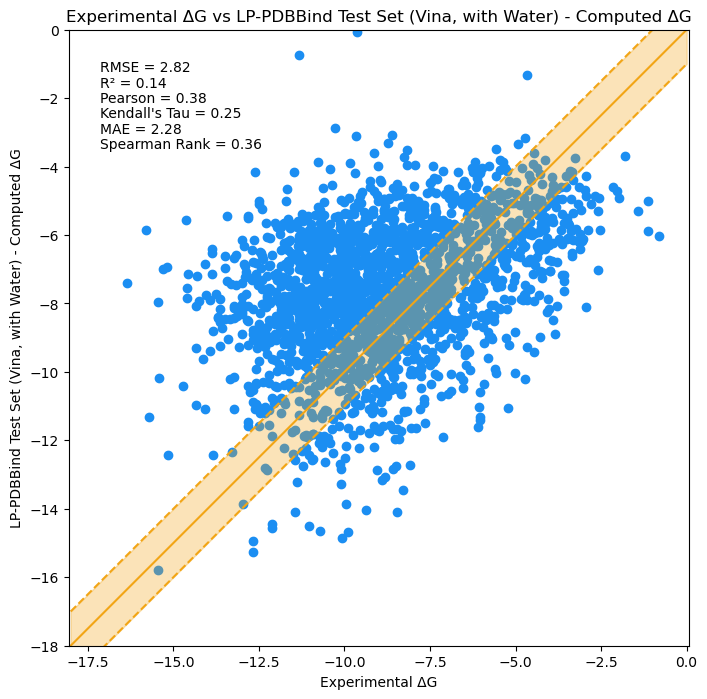

In [28]:
df = leakypdb_test_vina_water
plot_scatter(df['experimental_dG'], df['computed_dG'], 'Experimental ΔG', 'LP-PDBBind Test Set (Vina, with Water) - Computed ΔG')

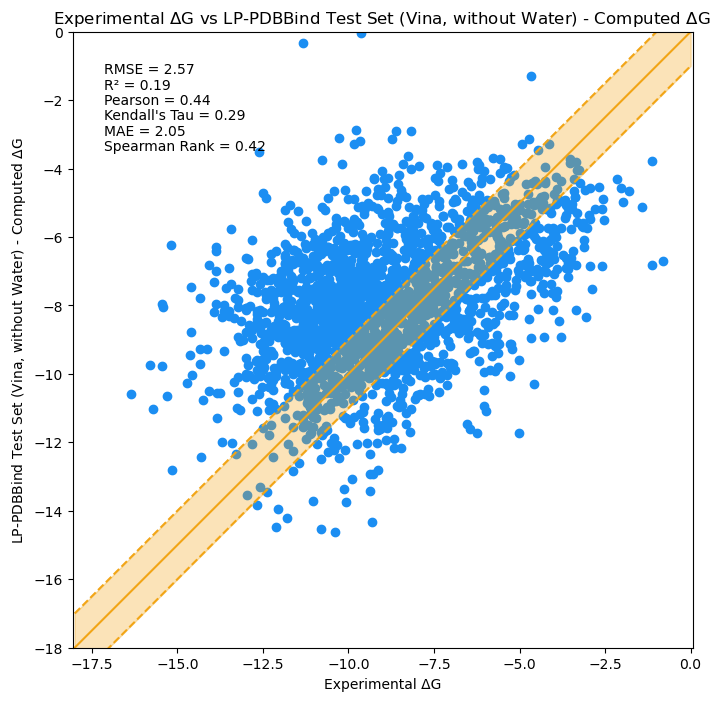

In [29]:
df = leakypdb_test_vina
plot_scatter(df['experimental_dG'], df['computed_dG'], r'Experimental ΔG', r'LP-PDBBind Test Set (Vina, without Water) - Computed $\Delta$G ')

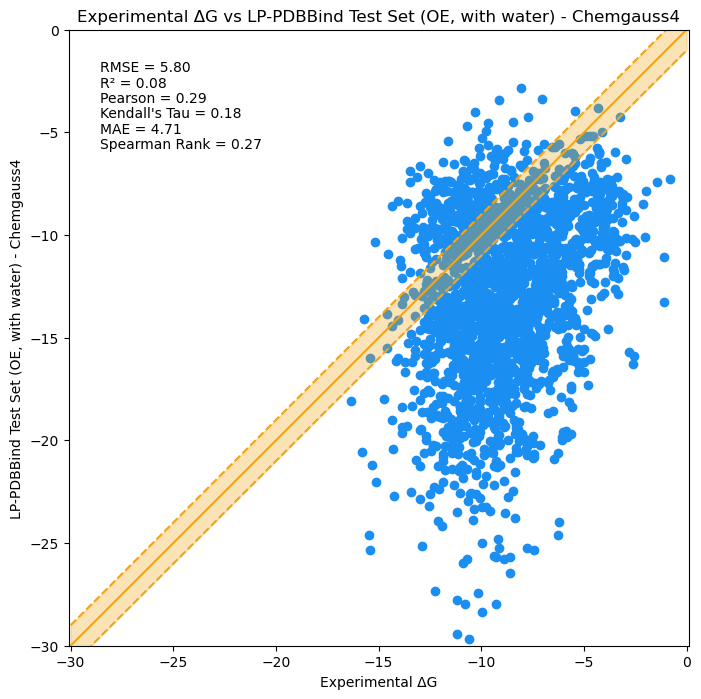

In [30]:
df = leakypdb_test_oe_water
plot_scatter(df['experimental_dG'], df['Chemgauss4'],'Experimental ΔG', 'LP-PDBBind Test Set (OE, with water) - Chemgauss4', min_X=-30)


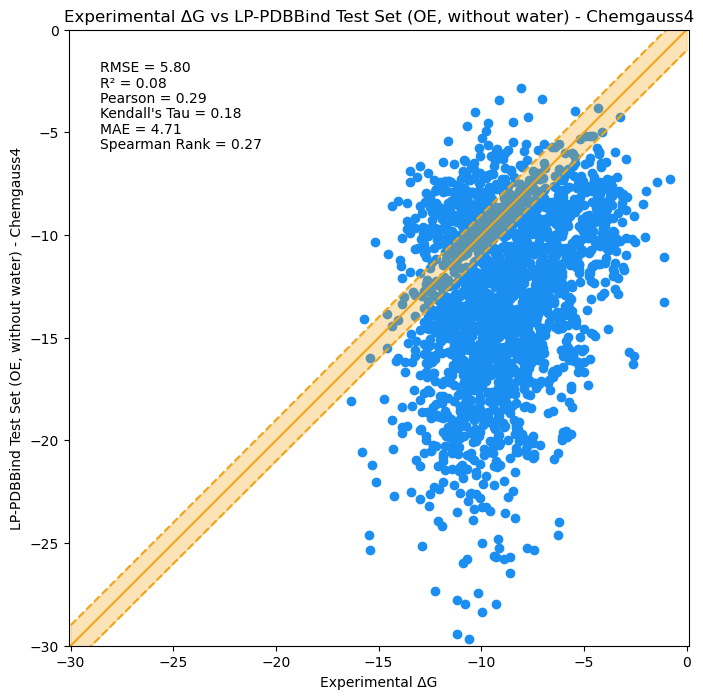

In [31]:
df = leakypdb_test_oe
plot_scatter(df['experimental_dG'], df['Chemgauss4'],'Experimental ΔG', 'LP-PDBBind Test Set (OE, without water) - Chemgauss4', min_X=-30)

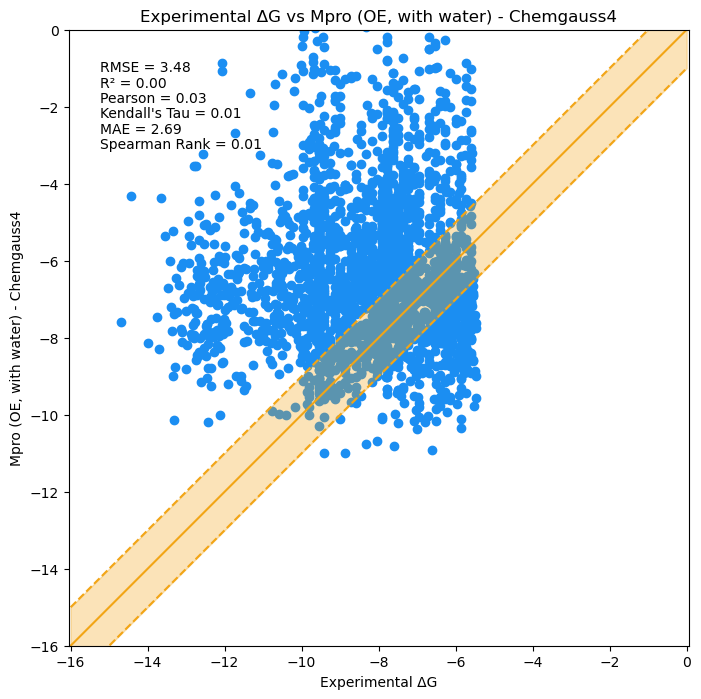

In [32]:
df = mpro_oe_water
plot_scatter(df['experimental_dG'], df['Chemgauss4'],'Experimental ΔG', 'Mpro (OE, with water) - Chemgauss4', min_X=-16)

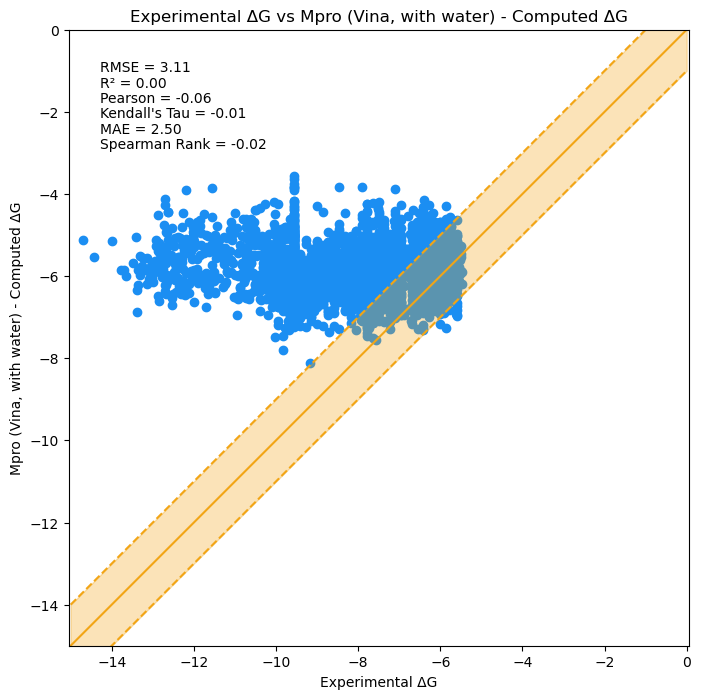

In [33]:
df = mpro_vina_water 
plot_scatter(df['experimental_dG'], df['computed_dG'],'Experimental ΔG', 'Mpro (Vina, with water) - Computed ΔG', min_X=-15)

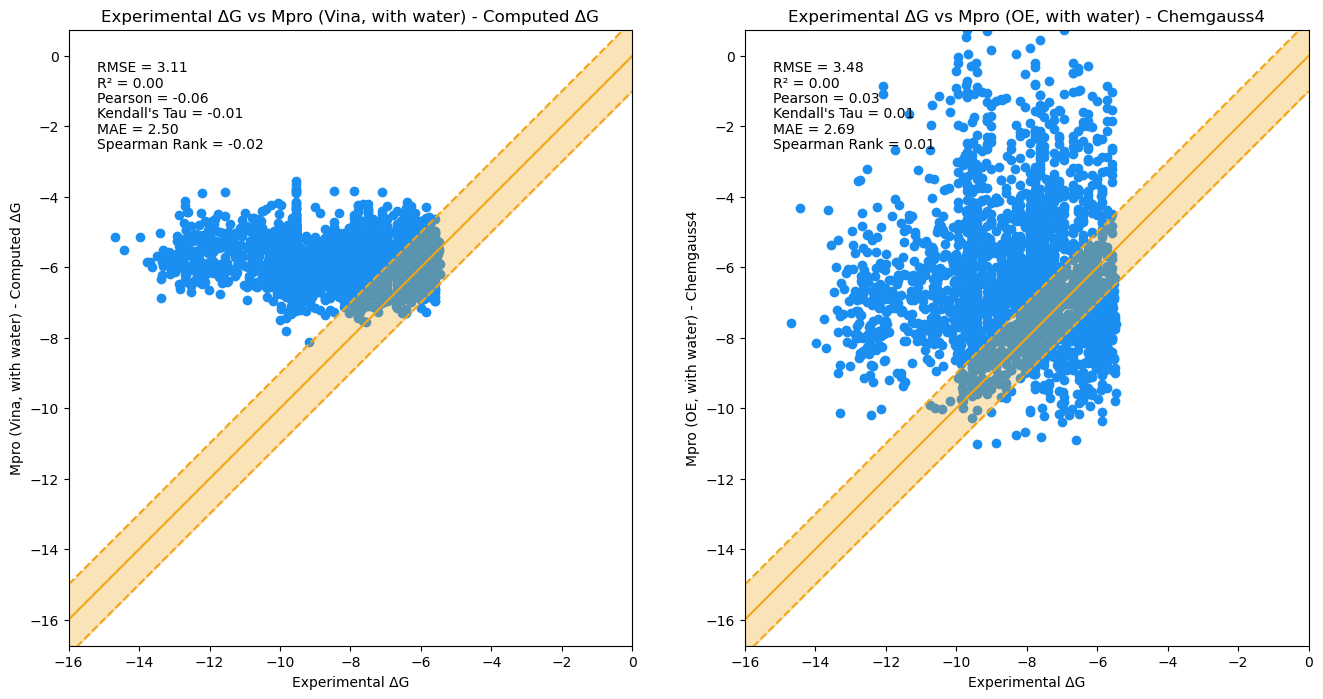

In [35]:
plot_side_by_side_scatter(mpro_vina_water['experimental_dG'], mpro_vina_water['computed_dG'], 'Experimental ΔG', 'Mpro (Vina, with water) - Computed ΔG', mpro_oe_water['experimental_dG'], mpro_oe_water['Chemgauss4'],'Experimental ΔG', 'Mpro (OE, with water) - Chemgauss4', min_X=-16)

#### Modifying the function slightly to plot things side by side

In [34]:
import matplotlib.pyplot as plt

def plot_side_by_side_scatter(X1, Y1, nameX1, nameY1, X2, Y2, nameX2, nameY2, min_X=-18):
    """
    Plot two scatter plots side by side for computed vs experimental dG values.

    Parameters:
    - X1, Y1: Data for the first plot
    - nameX1, nameY1: Names for the X and Y axes of the first plot
    - X2, Y2: Data for the second plot
    - nameX2, nameY2: Names for the X and Y axes of the second plot
    - min_X: Minimum value for the x-axis (default is -18)
    """
    
    # Create a figure with two subplots side by side
    fig, axs = plt.subplots(1, 2, figsize=(16, 8))
    
    # Plot the first scatter plot
    plot_scatter_on_axes(axs[0], X1, Y1, nameX1, nameY1, min_X)
    
    # Plot the second scatter plot
    plot_scatter_on_axes(axs[1], X2, Y2, nameX2, nameY2, min_X)

        # Replace unallowed characters in nameX and nameY for filename
    nameX1 = nameX1.replace(' ', '_').replace('/', '_').replace('(', '').replace(')', '').replace(':', '-').replace(',', '')
    nameY1 = nameY1.replace(' ', '_').replace('/', '_').replace('(', '').replace(')', '').replace(':', '-').replace(',', '')
    
    nameX2 = nameX2.replace(' ', '_').replace('/', '_').replace('(', '').replace(')', '').replace(':', '-').replace(',', '')
    nameY2 = nameY2.replace(' ', '_').replace('/', '_').replace('(', '').replace(')', '').replace(':', '-').replace(',', '')
    
    # Save the figure
    plt.savefig(f'figures/{nameX1}_{nameY1}_and_{nameX2}_{nameY2}.png')
    plt.show()

def plot_scatter_on_axes(ax, X, Y, nameX, nameY, min_X):
    """
    Plot a scatter plot on given axes.

    Parameters:
    - ax: The axes to plot on
    - X, Y: Data for the plot
    - nameX, nameY: Names for the X and Y axes
    - min_X: Minimum value for the x-axis
    """
    
    # Calculate metrics
    rmse = compute_RMSE(X, Y)
    pearson_correlation = compute_pearson_correlation(X, Y)
    R_2 = pearson_correlation ** 2
    kendall_tau = compute_kendall_tau(X, Y)
    mae = compute_mean_absolute_error(X, Y)
    spearman_rank_correlation = compute_spearman_rank_correlation(X, Y)
    
    # Scatter plot
    ax.scatter(X, Y, color='#1B8EF2')
    
    # Plot x=y line
    ax.plot([min_X, 0], [min_X, 0], color='#F2A516')
    
    # Plot RMSE deviation lines
    ax.plot([min_X, 0], [min_X + 1, 0 + 1], linestyle='--', color='#F2A516')
    ax.plot([min_X, 0], [min_X - 1, 0 - 1], linestyle='--', color='#F2A516')
    
    # Fill the region between the RMSE lines and the X=Y line
    ax.fill_between([min_X, 0], [min_X + 1, 0 + 1], [min_X - 1, 0 - 1], color='#F2A516', alpha=0.3)

    # Add text annotations
    ax.text(0.05, 0.95, f"RMSE = {rmse:.2f}", ha='left', va='top', transform=ax.transAxes)
    ax.text(0.05, 0.925, f"R\u00b2 = {R_2:.2f}", ha='left', va='top', transform=ax.transAxes)
    ax.text(0.05, 0.90, f"Pearson = {pearson_correlation:.2f}", ha='left', va='top', transform=ax.transAxes)
    ax.text(0.05, 0.875, f"Kendall's Tau = {kendall_tau:.2f}", ha='left', va='top', transform=ax.transAxes)
    ax.text(0.05, 0.85, f"MAE = {mae:.2f}", ha='left', va='top', transform=ax.transAxes)
    ax.text(0.05, 0.825, f"Spearman Rank = {spearman_rank_correlation:.2f}", ha='left', va='top', transform=ax.transAxes)
    
    # Set axis labels and title
    ax.set_xlabel(f'{nameX}')
    ax.set_ylabel(f'{nameY}')
    ax.set_title(f'{nameX} vs {nameY}')
    ax.axis('equal')
    ax.set_xlim(min_X, 0)
    ax.set_ylim(min_X, 0)

# Example usage
# Assuming X1, Y1, X2, Y2 are predefined datasets
# plot_side_by_side_scatter(X1, Y1, "Vina Computed", "Experimental", X2, Y2, "OE Computed", "Experimental")


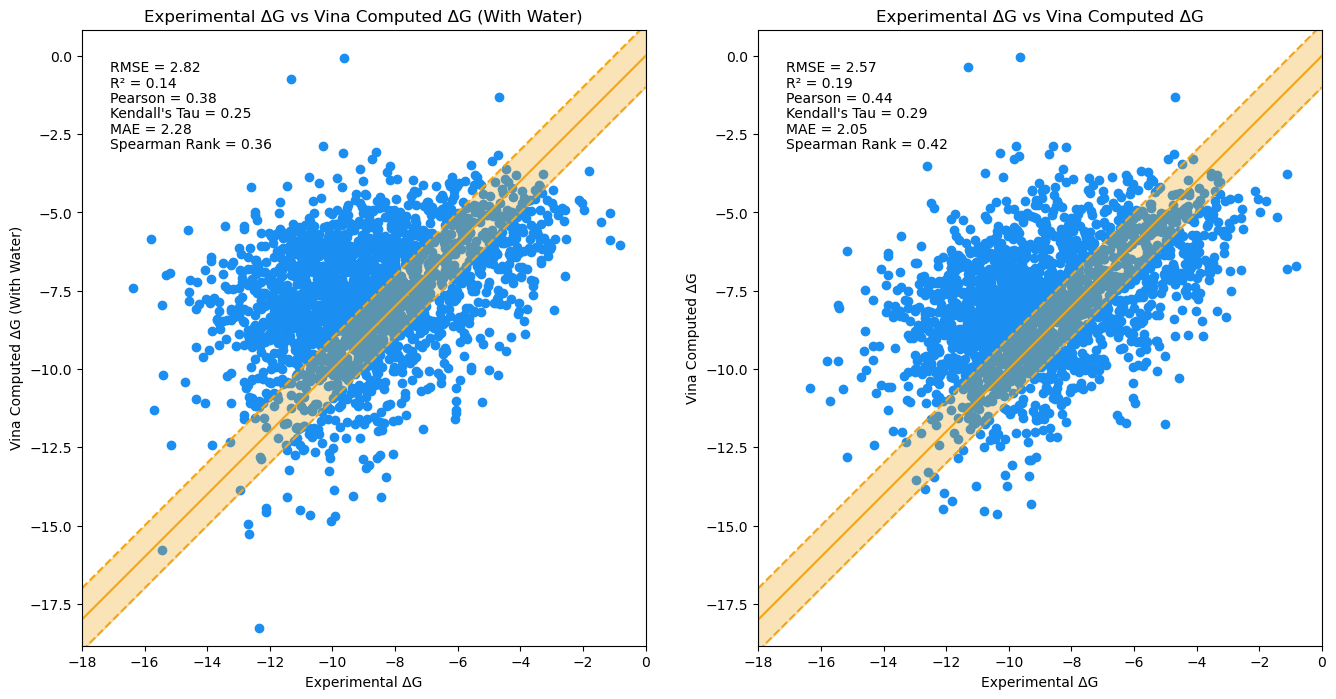

In [36]:
plot_side_by_side_scatter(leakypdb_test_vina_water['experimental_dG'], leakypdb_test_vina_water['computed_dG'], "Experimental ΔG", "Vina Computed ΔG (With Water)", leakypdb_test_vina['experimental_dG'], leakypdb_test_vina['computed_dG'], "Experimental ΔG", "Vina Computed ΔG")

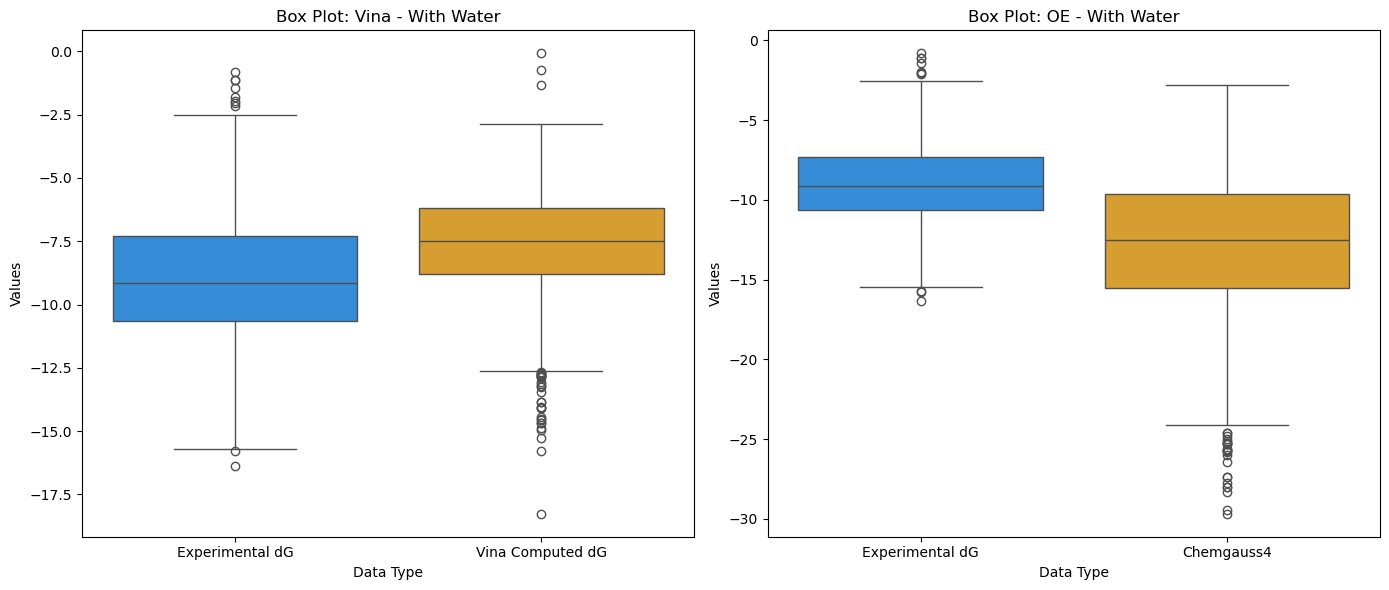

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Assuming merged_df1 and merged_df2 are already defined

# Prepare data for box plots
data1 = pd.DataFrame({
    'Experimental dG': leakypdb_test_vina_water['experimental_dG'],
    'Vina Computed dG': leakypdb_test_vina_water['computed_dG'],
    'Type': ['With Water'] * len(leakypdb_test_vina_water)
})


data2 = pd.DataFrame({
    'Experimental dG': leakypdb_test_oe_water['experimental_dG'],
    'Chemgauss4': leakypdb_test_oe_water['Chemgauss4'],
    'Type': ['With Water'] * len(leakypdb_test_oe_water)
})

# Combine data
combined_data = pd.concat([data1, data2])

# Create box plots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Box plot for 'With Water'
sns.boxplot(ax=axes[0], data=data1, palette=['#1B8EF2','#F2A516'])
axes[0].set_title('Box Plot: Vina - With Water')
axes[0].set_xlabel('Data Type')
axes[0].set_ylabel('Values')

# Box plot for 'Without Water'
sns.boxplot(ax=axes[1], data=data2, palette=['#1B8EF2','#F2A516'])
axes[1].set_title('Box Plot: OE - With Water')
axes[1].set_xlabel('Data Type')
axes[1].set_ylabel('Values')

plt.tight_layout()
plt.show()

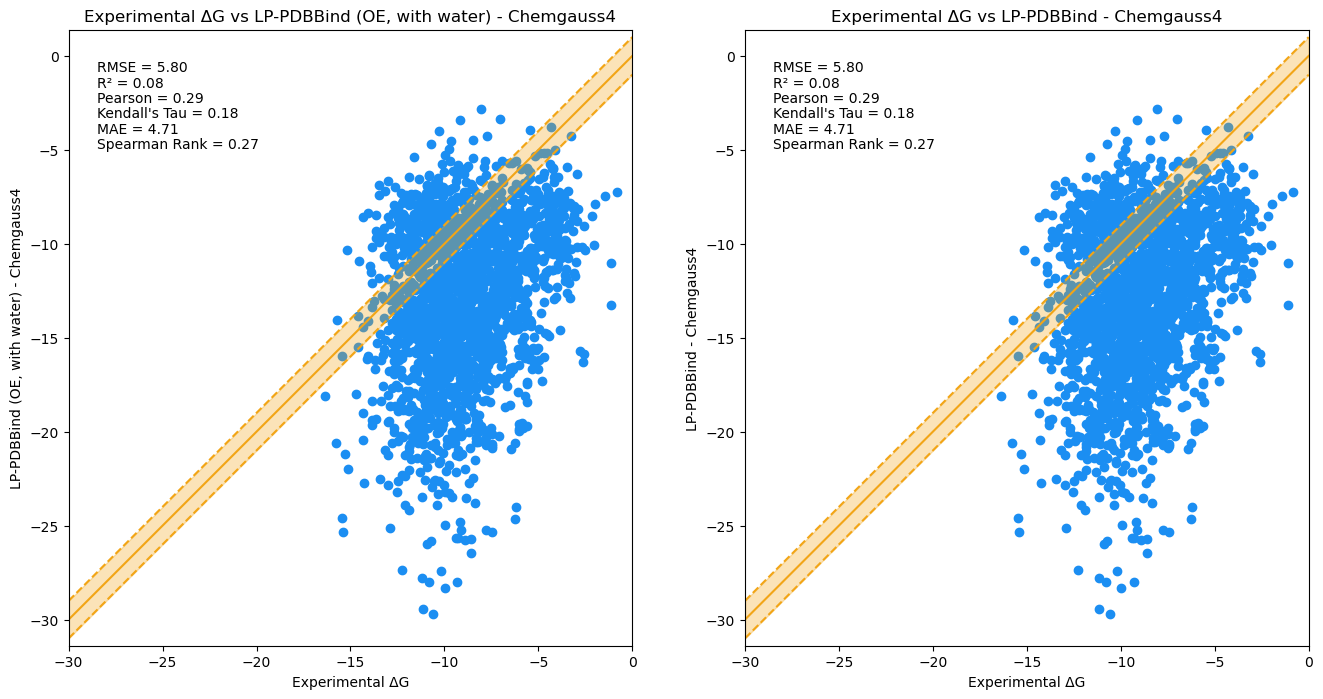

In [38]:
plot_side_by_side_scatter(leakypdb_test_oe_water['experimental_dG'], leakypdb_test_oe_water['Chemgauss4'], 'Experimental ΔG', 'LP-PDBBind (OE, with water) - Chemgauss4',
leakypdb_test_oe['experimental_dG'], leakypdb_test_oe['Chemgauss4'],'Experimental ΔG', 'LP-PDBBind - Chemgauss4', min_X=-30)

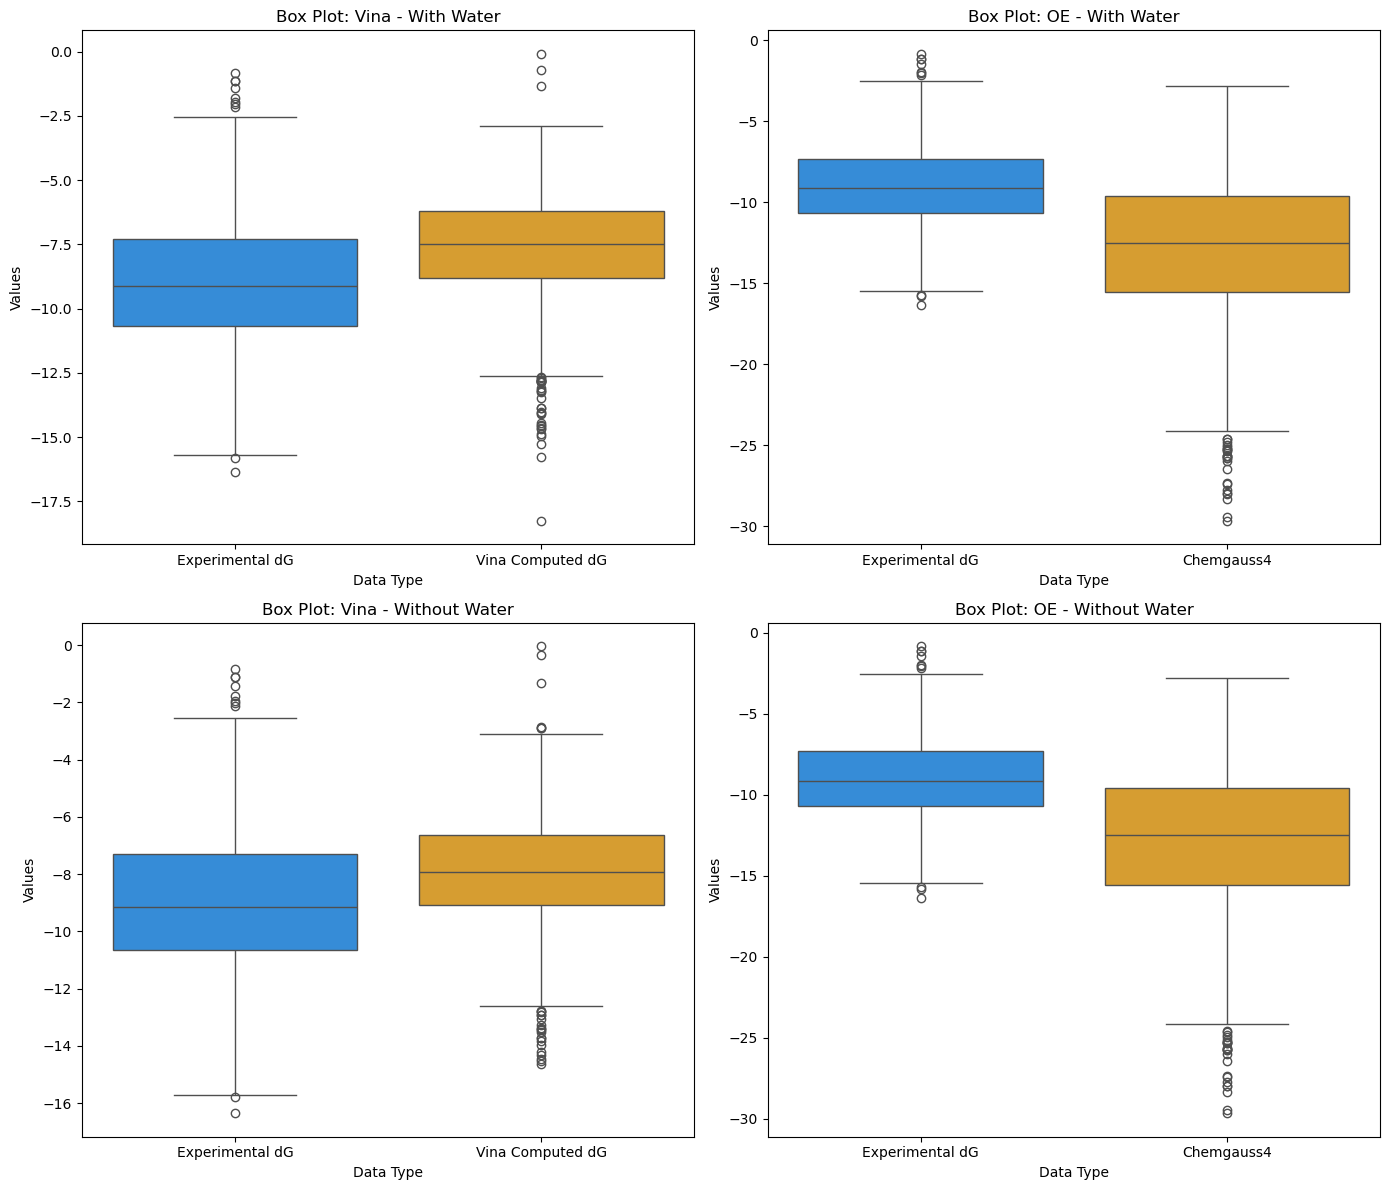

In [39]:
import seaborn as sns
import pandas as pd

import matplotlib.pyplot as plt

# Assuming merged_df1 and merged_df2 are already defined

# Prepare data for box plots
data1 = pd.DataFrame({
    'Experimental dG': leakypdb_test_vina_water['experimental_dG'],
    'Vina Computed dG': leakypdb_test_vina_water['computed_dG'],
    'Type': ['With Water'] * len(leakypdb_test_vina_water)
})


data2 = pd.DataFrame({
    'Experimental dG': leakypdb_test_oe_water['experimental_dG'],
    'Chemgauss4': leakypdb_test_oe_water['Chemgauss4'],
    'Type': ['With Water'] * len(leakypdb_test_oe_water)
})

data3 = pd.DataFrame({
    'Experimental dG': leakypdb_test_vina['experimental_dG'],
    'Vina Computed dG': leakypdb_test_vina['computed_dG'],
    'Type': ['Without Water'] * len(leakypdb_test_vina)
})


data4 = pd.DataFrame({
    'Experimental dG': leakypdb_test_oe['experimental_dG'],
    'Chemgauss4': leakypdb_test_oe['Chemgauss4'],
    'Type': ['Without Water'] * len(leakypdb_test_oe)
})

# Combine data
combined_data = pd.concat([data1, data2, data3, data4])

# Create box plots
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# Box plot for 'With Water' - Vina
sns.boxplot(ax=axes[0, 0], data=data1, palette=['#1B8EF2','#F2A516'])
axes[0, 0].set_title('Box Plot: Vina - With Water')
axes[0, 0].set_xlabel('Data Type')
axes[0, 0].set_ylabel('Values')

# Box plot for 'With Water' - OE
sns.boxplot(ax=axes[0, 1], data=data2, palette=['#1B8EF2','#F2A516'])
axes[0, 1].set_title('Box Plot: OE - With Water')
axes[0, 1].set_xlabel('Data Type')
axes[0, 1].set_ylabel('Values')

# Box plot for 'Without Water' - Vina
sns.boxplot(ax=axes[1, 0], data=data3, palette=['#1B8EF2','#F2A516'])
axes[1, 0].set_title('Box Plot: Vina - Without Water')
axes[1, 0].set_xlabel('Data Type')
axes[1, 0].set_ylabel('Values')

# Box plot for 'Without Water' - OE
sns.boxplot(ax=axes[1, 1], data=data4, palette=['#1B8EF2','#F2A516'])
axes[1, 1].set_title('Box Plot: OE - Without Water')
axes[1, 1].set_xlabel('Data Type')
axes[1, 1].set_ylabel('Values')

plt.tight_layout()
plt.show()


### Cross comparison between the two docking platforms
LP-PDBBind

In [40]:
import pandas as pd
import matplotlib.pyplot as plt

def merge_dataframes(df1, df2, key_column=None):
    """
    Merge two DataFrames on a common key or index.

    Parameters:
    - df1: First DataFrame
    - df2: Second DataFrame
    - key_column: Optional, the column name on which to merge the DataFrames. If None, merge on index.

    Returns:
    - Merged DataFrame
    """
    if key_column:
        # Merge on a specific column
        merged_df = pd.merge(df1, df2, on=key_column)
    else:
        # Merge on index
        merged_df = pd.merge(df1, df2, left_index=True, right_index=True)

    # Drop any rows with NaN values in the columns of interest
    merged_df = merged_df.dropna(subset=['computed_dG', 'Chemgauss4'])

    return merged_df


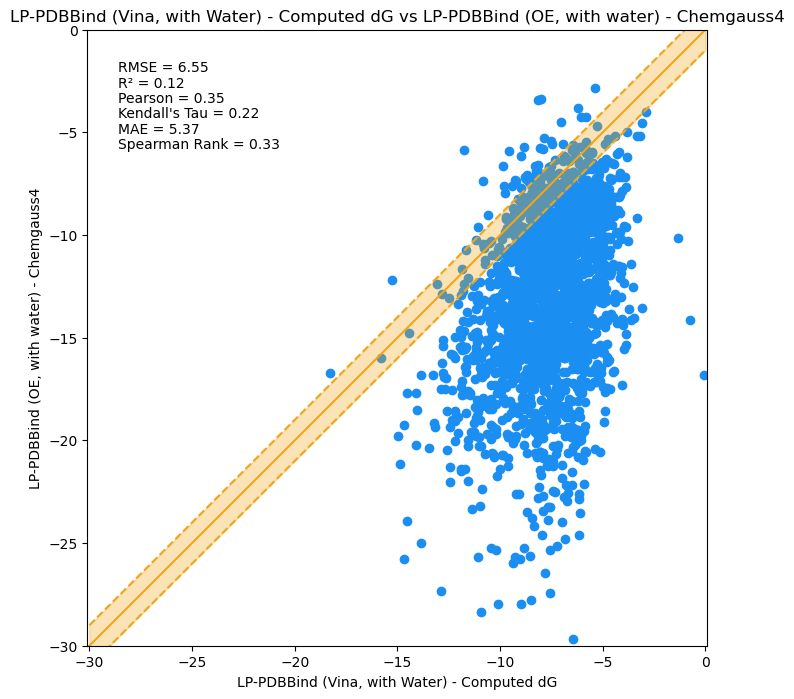

In [41]:
# With water
# Merge DataFrames
merged_df = merge_dataframes(leakypdb_test_vina_water, leakypdb_test_oe_water, key_column='pdb_id')

# Plot scatter plot using merged data
plot_scatter(merged_df['computed_dG'], merged_df['Chemgauss4'], 
             'LP-PDBBind (Vina, with Water) - Computed dG', 
             'LP-PDBBind (OE, with water) - Chemgauss4', min_X=-30)


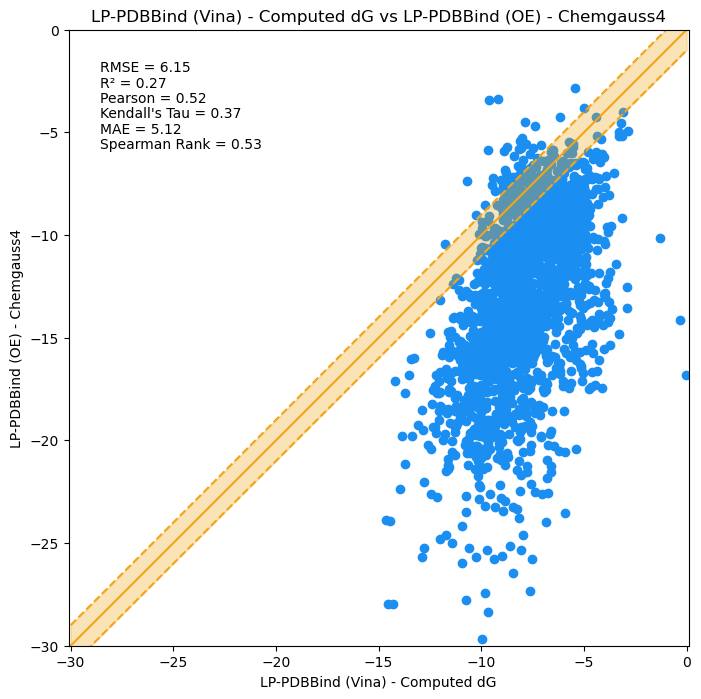

In [42]:
# without water
# Merge DataFrames
merged_df = merge_dataframes(leakypdb_test_vina, leakypdb_test_oe, key_column='pdb_id')

# Plot scatter plot using merged data
plot_scatter(merged_df['computed_dG'], merged_df['Chemgauss4'], 
             'LP-PDBBind (Vina) - Computed dG', 
             'LP-PDBBind (OE) - Chemgauss4', min_X=-30)


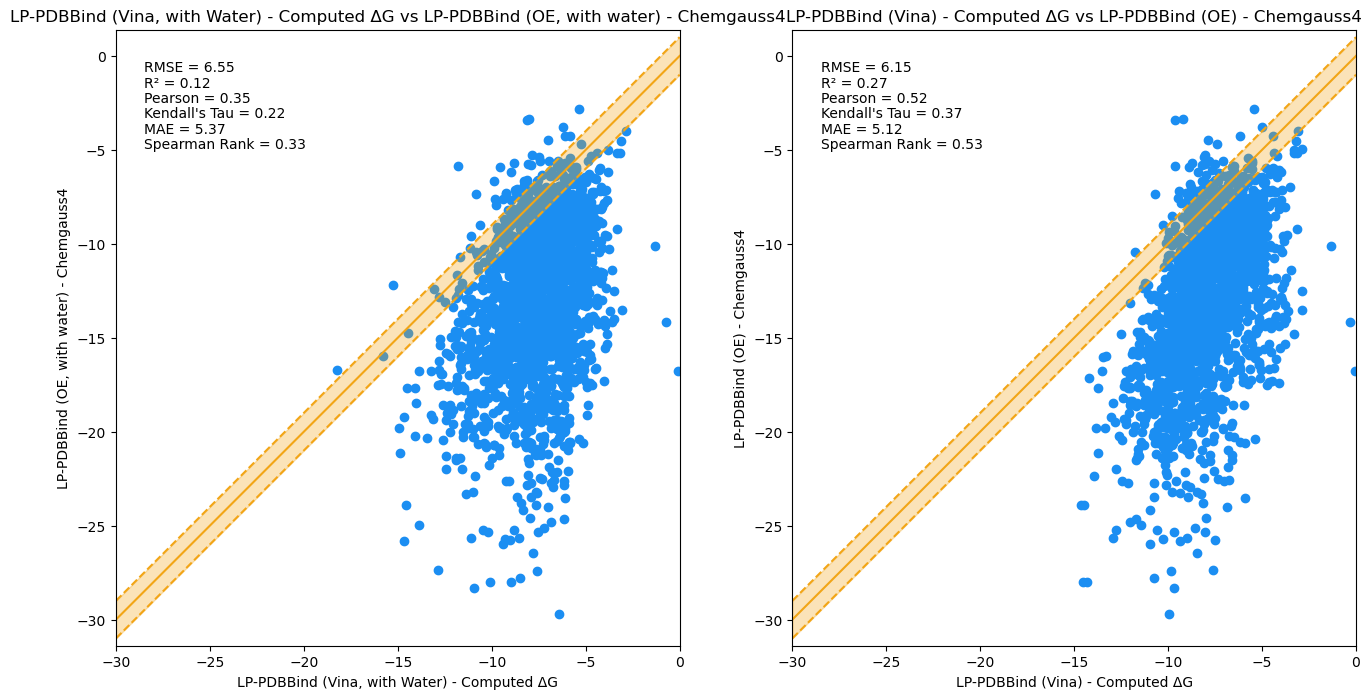

In [44]:
# cross comparison: with & without water
merged_df1 = merge_dataframes(leakypdb_test_vina_water, leakypdb_test_oe_water, key_column='pdb_id')
merged_df2 = merge_dataframes(leakypdb_test_vina, leakypdb_test_oe, key_column='pdb_id')
# Plot scatter plot using merged data
plot_side_by_side_scatter(merged_df1['computed_dG'], merged_df1['Chemgauss4'], 
             'LP-PDBBind (Vina, with Water) - Computed ΔG', 
             'LP-PDBBind (OE, with water) - Chemgauss4',
merged_df2['computed_dG'], merged_df2['Chemgauss4'], 
             'LP-PDBBind (Vina) - Computed ΔG', 
             'LP-PDBBind (OE) - Chemgauss4', min_X=-30)

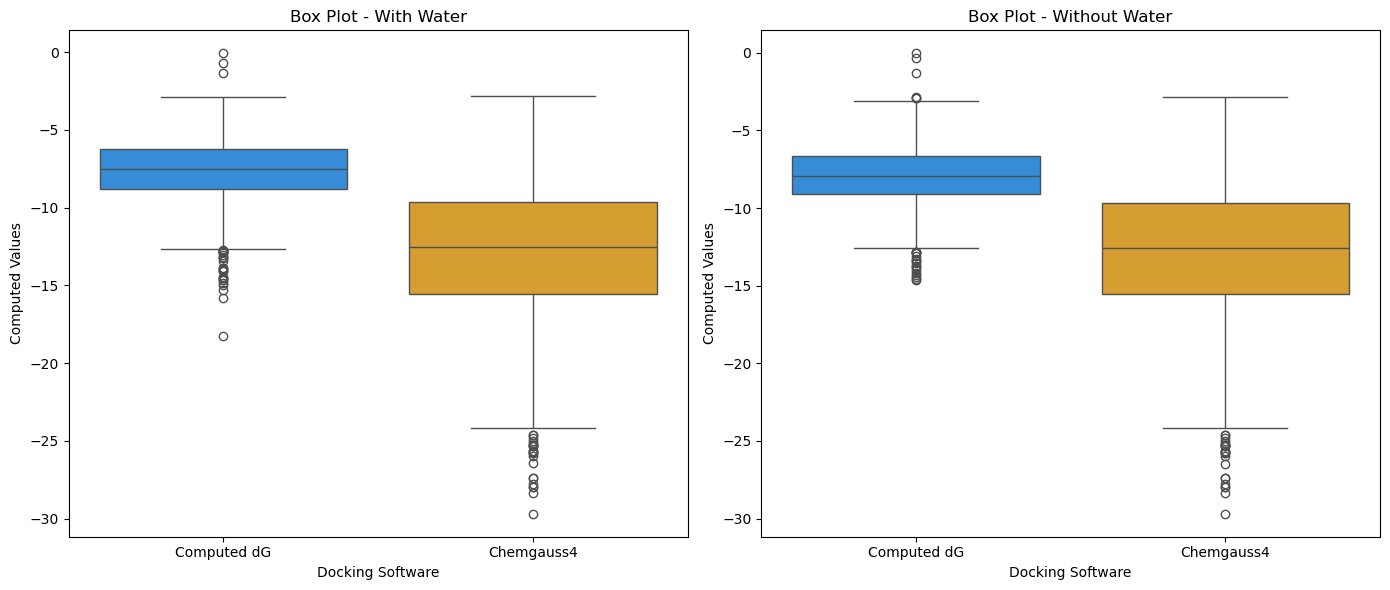

In [45]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

merged_df1 = merge_dataframes(leakypdb_test_vina_water, leakypdb_test_oe_water, key_column='pdb_id')
merged_df2 = merge_dataframes(leakypdb_test_vina, leakypdb_test_oe, key_column='pdb_id')
# Prepare data for box plots
data1 = pd.DataFrame({
    'Computed dG': merged_df1['computed_dG'],
    'Chemgauss4': merged_df1['Chemgauss4'],
    'Type': ['With Water'] * len(merged_df1)
})

data2 = pd.DataFrame({
    'Computed dG': merged_df2['computed_dG'],
    'Chemgauss4': merged_df2['Chemgauss4'],
    'Type': ['Without Water'] * len(merged_df2)
})

# Combine data
combined_data = pd.concat([data1, data2])

# Create box plots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Box plot for 'With Water'
sns.boxplot(ax=axes[0], data=data1, palette=['#1B8EF2','#F2A516'])
axes[0].set_title('Box Plot - With Water')
axes[0].set_xlabel('Docking Software')
axes[0].set_ylabel('Computed Values')

# Box plot for 'Without Water'
sns.boxplot(ax=axes[1], data=data2, palette=['#1B8EF2','#F2A516'])
axes[1].set_title('Box Plot - Without Water')
axes[1].set_xlabel('Docking Software')
axes[1].set_ylabel('Computed Values')

plt.tight_layout()
plt.show()

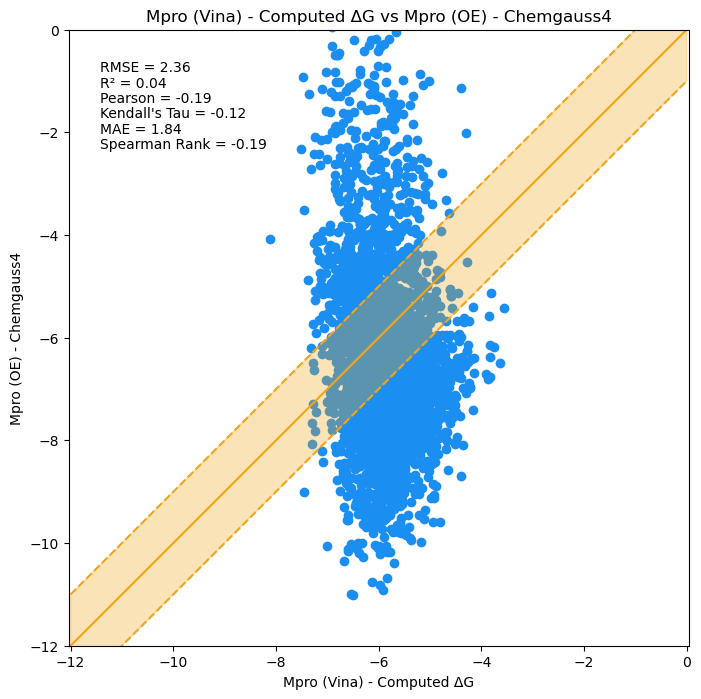

In [46]:
# Mpro: vina vs OE

# Merge DataFrames
merged_df = merge_dataframes(mpro_vina_water, mpro_oe_water, key_column='ligand_name')

# Plot scatter plot using merged data
plot_scatter(merged_df['computed_dG'], merged_df['Chemgauss4'], 
             'Mpro (Vina) - Computed ΔG', 
             'Mpro (OE) - Chemgauss4', min_X=-12)

# Bootstraping the data, to get R2, Tau and Spearman Rank on a boxplot

/tmp/ipykernel_3536927/3627843619.py:100: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Population', y='$R^2$', data=results_df, ax=axes[0, 0], palette=['#1B8EF2','#F2A516'])
/tmp/ipykernel_3536927/3627843619.py:105: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Population', y='Kendall Tau', data=results_df, ax=axes[1, 0], palette=['#1B8EF2','#F2A516'])
/tmp/ipykernel_3536927/3627843619.py:110: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Population', y='Spearman Rank', data=results_df, ax=axes[2, 0], palette=['#1B8EF2','#F2A516'])

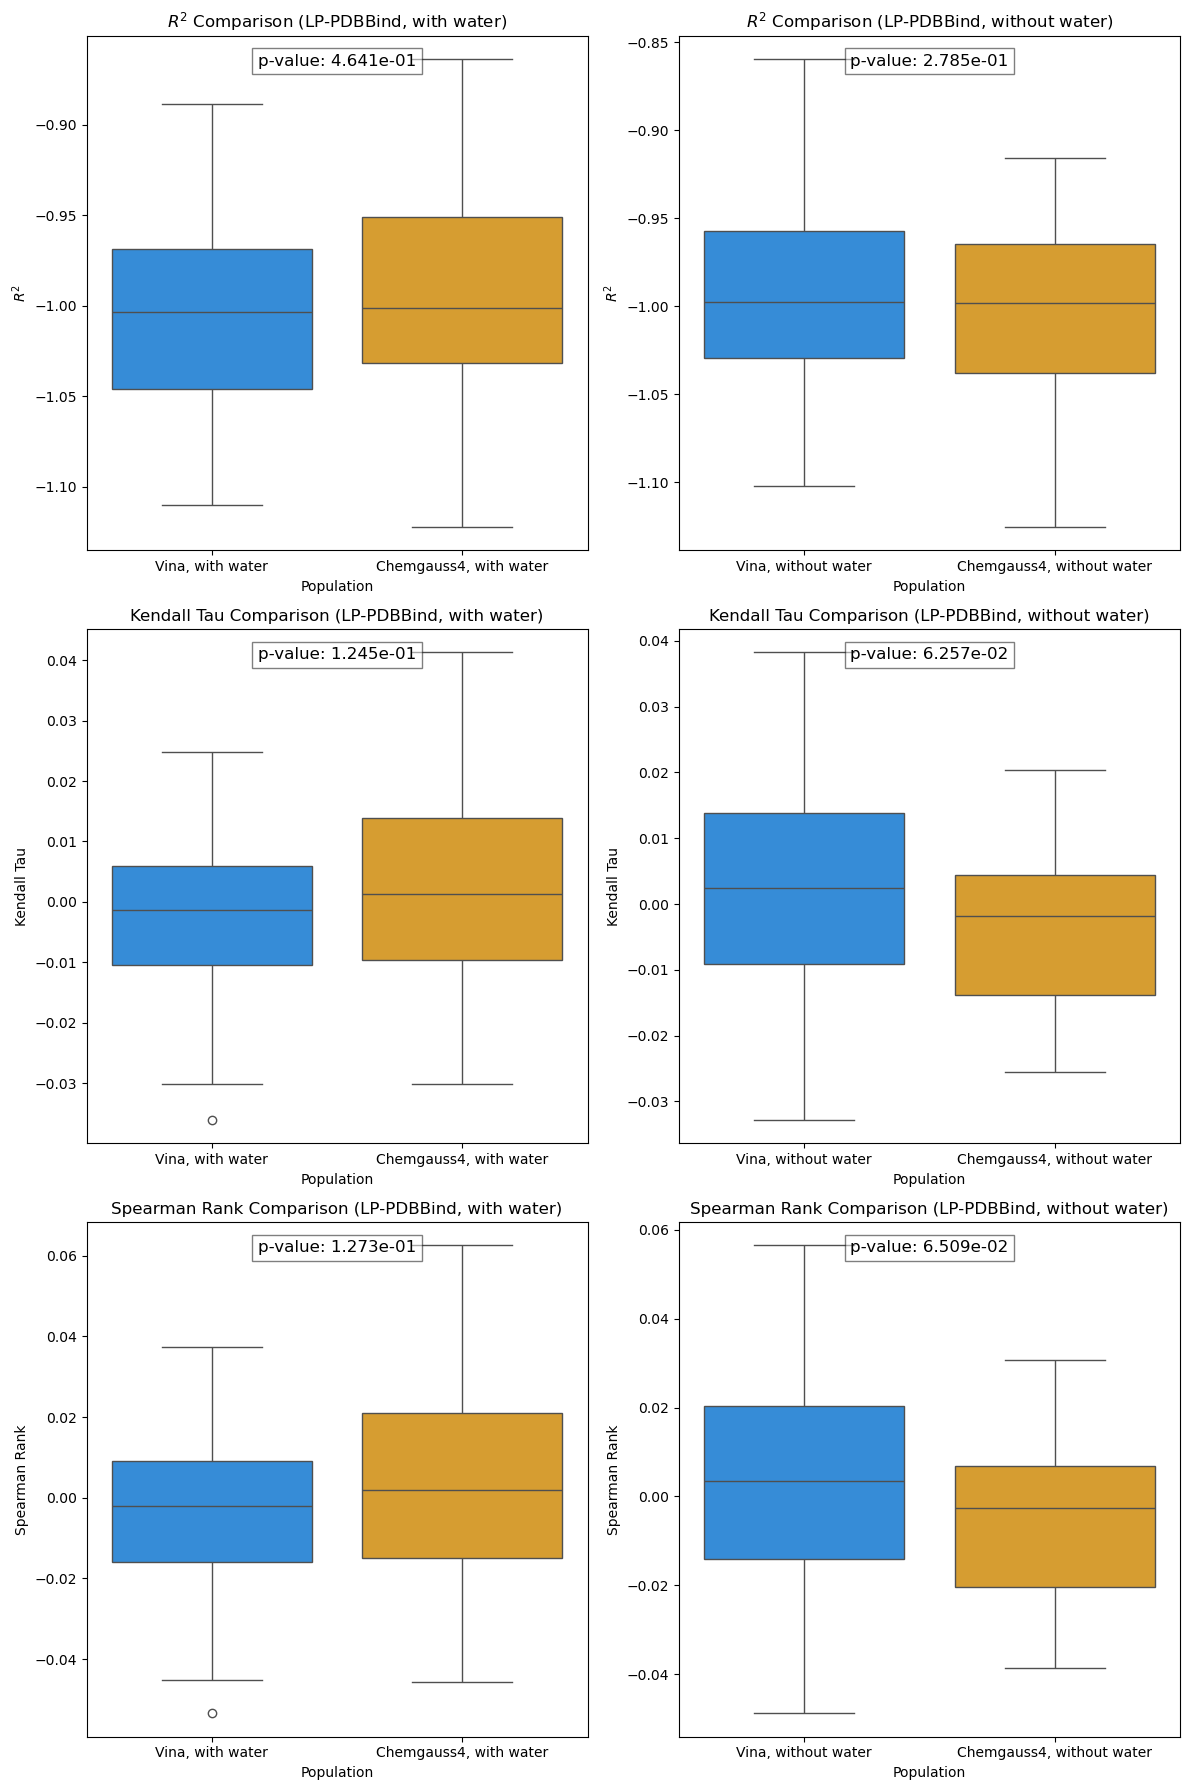

In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import kendalltau, spearmanr, mannwhitneyu, shapiro, f_oneway, ttest_ind
from sklearn.metrics import r2_score

################## WITH WATER ##################
population1 = leakypdb_test_vina_water['computed_dG']
population2 = leakypdb_test_oe_water['Chemgauss4']
n_samples= 50

# Initialize lists to store results
r2_values_pop1 = []
kendall_tau_values_pop1 = []
spearman_rank_values_pop1 = []

r2_values_pop2 = []
kendall_tau_values_pop2 = []
spearman_rank_values_pop2 = []

# Perform bootstrap sampling for population 1
for _ in range(n_samples):
    sample1 = population1.sample(frac=1, replace=True)
    
    # Compute R²
    r2 = r2_score(population1, sample1)
    r2_values_pop1.append(r2)
    
    # Compute Kendall Tau
    tau, _ = kendalltau(population1, sample1)
    kendall_tau_values_pop1.append(tau)
    
    # Compute Spearman Rank
    spearman, _ = spearmanr(population1, sample1)
    spearman_rank_values_pop1.append(spearman)

# Perform bootstrap sampling for population 2
for _ in range(n_samples):
    sample2 = population2.sample(frac=1, replace=True)
    
    # Compute R²
    r2 = r2_score(population2, sample2)
    r2_values_pop2.append(r2)
    
    # Compute Kendall Tau
    tau, _ = kendalltau(population2, sample2)
    kendall_tau_values_pop2.append(tau)
    
    # Compute Spearman Rank
    spearman, _ = spearmanr(population2, sample2)
    spearman_rank_values_pop2.append(spearman)

# Create DataFrames from the results
results_df_pop1 = pd.DataFrame({
    '$R^2$': r2_values_pop1,
    'Kendall Tau': kendall_tau_values_pop1,
    'Spearman Rank': spearman_rank_values_pop1,
    'Population': 'Vina, with water'
})

results_df_pop2 = pd.DataFrame({
    '$R^2$': r2_values_pop2,
    'Kendall Tau': kendall_tau_values_pop2,
    'Spearman Rank': spearman_rank_values_pop2,
    'Population': 'Chemgauss4, with water'
})

# Concatenate the results
results_df = pd.concat([results_df_pop1, results_df_pop2])

# Check if data is normally distributed
_, p_pop1_r2 = shapiro(r2_values_pop1)
_, p_pop2_r2 = shapiro(r2_values_pop2)
_, p_pop1_kendall = shapiro(kendall_tau_values_pop1)
_, p_pop2_kendall = shapiro(kendall_tau_values_pop2)
_, p_pop1_spearman = shapiro(spearman_rank_values_pop1)
_, p_pop2_spearman = shapiro(spearman_rank_values_pop2)

# Perform appropriate statistical tests
if p_pop1_r2 > 0.05 and p_pop2_r2 > 0.05:
    _, p_value_r2 = f_oneway(r2_values_pop1, r2_values_pop2)
else:
    _, p_value_r2 = mannwhitneyu(r2_values_pop1, r2_values_pop2)

if p_pop1_kendall > 0.05 and p_pop2_kendall > 0.05:
    _, p_value_kendall = f_oneway(kendall_tau_values_pop1, kendall_tau_values_pop2)
else:
    _, p_value_kendall = mannwhitneyu(kendall_tau_values_pop1, kendall_tau_values_pop2)

if p_pop1_spearman > 0.05 and p_pop2_spearman > 0.05:
    _, p_value_spearman = f_oneway(spearman_rank_values_pop1, spearman_rank_values_pop2)
else:
    _, p_value_spearman = mannwhitneyu(spearman_rank_values_pop1, spearman_rank_values_pop2)

# Create a new figure with 3 rows and 2 columns
fig, axes = plt.subplots(3, 2, figsize=(12, 18))

# Plot R² Comparison for "with water"
sns.boxplot(x='Population', y='$R^2$', data=results_df, ax=axes[0, 0], palette=['#1B8EF2','#F2A516'])
axes[0, 0].set_title('$R^2$ Comparison (LP-PDBBind, with water)')
axes[0, 0].text(0.5, 0.95, f'p-value: {p_value_r2:.3e}', ha='center', va='center', transform=axes[0, 0].transAxes, fontsize=12, bbox=dict(facecolor='white', alpha=0.5))

# Plot Kendall Tau Comparison for "with water"
sns.boxplot(x='Population', y='Kendall Tau', data=results_df, ax=axes[1, 0], palette=['#1B8EF2','#F2A516'])
axes[1, 0].set_title('Kendall Tau Comparison (LP-PDBBind, with water)')
axes[1, 0].text(0.5, 0.95, f'p-value: {p_value_kendall:.3e}', ha='center', va='center', transform=axes[1, 0].transAxes, fontsize=12, bbox=dict(facecolor='white', alpha=0.5))

# Plot Spearman Rank Comparison for "with water"
sns.boxplot(x='Population', y='Spearman Rank', data=results_df, ax=axes[2, 0], palette=['#1B8EF2','#F2A516'])
axes[2, 0].set_title('Spearman Rank Comparison (LP-PDBBind, with water)')
axes[2, 0].text(0.5, 0.95, f'p-value: {p_value_spearman:.3e}', ha='center', va='center', transform=axes[2, 0].transAxes, fontsize=12, bbox=dict(facecolor='white', alpha=0.5))

# Now update results_df with the data from "without water" analysis

population1 = leakypdb_test_vina['computed_dG']
population2 = leakypdb_test_oe['Chemgauss4']
n_samples= 50

# Initialize lists to store results
r2_values_pop1 = []
kendall_tau_values_pop1 = []
spearman_rank_values_pop1 = []

r2_values_pop2 = []
kendall_tau_values_pop2 = []
spearman_rank_values_pop2 = []

# Perform bootstrap sampling for population 1
for _ in range(n_samples):
    sample1 = population1.sample(frac=1, replace=True)
    
    # Compute R²
    r2 = r2_score(population1, sample1)
    r2_values_pop1.append(r2)
    
    # Compute Kendall Tau
    tau, _ = kendalltau(population1, sample1)
    kendall_tau_values_pop1.append(tau)
    
    # Compute Spearman Rank
    spearman, _ = spearmanr(population1, sample1)
    spearman_rank_values_pop1.append(spearman)

# Perform bootstrap sampling for population 2
for _ in range(n_samples):
    sample2 = population2.sample(frac=1, replace=True)
    
    # Compute R²
    r2 = r2_score(population2, sample2)
    r2_values_pop2.append(r2)
    
    # Compute Kendall Tau
    tau, _ = kendalltau(population2, sample2)
    kendall_tau_values_pop2.append(tau)
    
    # Compute Spearman Rank
    spearman, _ = spearmanr(population2, sample2)
    spearman_rank_values_pop2.append(spearman)

# Create DataFrames from the results
results_df_pop1 = pd.DataFrame({
    '$R^2$': r2_values_pop1,
    'Kendall Tau': kendall_tau_values_pop1,
    'Spearman Rank': spearman_rank_values_pop1,
    'Population': 'Vina, without water'
})

results_df_pop2 = pd.DataFrame({
    '$R^2$': r2_values_pop2,
    'Kendall Tau': kendall_tau_values_pop2,
    'Spearman Rank': spearman_rank_values_pop2,
    'Population': 'Chemgauss4, without water'
})

# Concatenate the results
results_df = pd.concat([results_df_pop1, results_df_pop2])

# Check if data is normally distributed
_, p_pop1_r2 = shapiro(r2_values_pop1)
_, p_pop2_r2 = shapiro(r2_values_pop2)
_, p_pop1_kendall = shapiro(kendall_tau_values_pop1)
_, p_pop2_kendall = shapiro(kendall_tau_values_pop2)
_, p_pop1_spearman = shapiro(spearman_rank_values_pop1)
_, p_pop2_spearman = shapiro(spearman_rank_values_pop2)

# Perform appropriate statistical tests
if p_pop1_r2 > 0.05 and p_pop2_r2 > 0.05:
    _, p_value_r2 = f_oneway(r2_values_pop1, r2_values_pop2)
else:
    _, p_value_r2 = mannwhitneyu(r2_values_pop1, r2_values_pop2)

if p_pop1_kendall > 0.05 and p_pop2_kendall > 0.05:
    _, p_value_kendall = f_oneway(kendall_tau_values_pop1, kendall_tau_values_pop2)
else:
    _, p_value_kendall = mannwhitneyu(kendall_tau_values_pop1, kendall_tau_values_pop2)

if p_pop1_spearman > 0.05 and p_pop2_spearman > 0.05:
    _, p_value_spearman = f_oneway(spearman_rank_values_pop1, spearman_rank_values_pop2)
else:
    _, p_value_spearman = mannwhitneyu(spearman_rank_values_pop1, spearman_rank_values_pop2)
# Assuming similar process as before, the results_df now contains "without water" data

# Plot R² Comparison for "without water"
sns.boxplot(x='Population', y='$R^2$', data=results_df, ax=axes[0, 1], palette=['#1B8EF2','#F2A516'])
axes[0, 1].set_title('$R^2$ Comparison (LP-PDBBind, without water)')
axes[0, 1].text(0.5, 0.95, f'p-value: {p_value_r2:.3e}', ha='center', va='center', transform=axes[0, 1].transAxes, fontsize=12, bbox=dict(facecolor='white', alpha=0.5))

# Plot Kendall Tau Comparison for "without water"
sns.boxplot(x='Population', y='Kendall Tau', data=results_df, ax=axes[1, 1], palette=['#1B8EF2','#F2A516'])
axes[1, 1].set_title('Kendall Tau Comparison (LP-PDBBind, without water)')
axes[1, 1].text(0.5, 0.95, f'p-value: {p_value_kendall:.3e}', ha='center', va='center', transform=axes[1, 1].transAxes, fontsize=12, bbox=dict(facecolor='white', alpha=0.5))

# Plot Spearman Rank Comparison for "without water"
sns.boxplot(x='Population', y='Spearman Rank', data=results_df, ax=axes[2, 1], palette=['#1B8EF2','#F2A516'])
axes[2, 1].set_title('Spearman Rank Comparison (LP-PDBBind, without water)')
axes[2, 1].text(0.5, 0.95, f'p-value: {p_value_spearman:.3e}', ha='center', va='center', transform=axes[2, 1].transAxes, fontsize=12, bbox=dict(facecolor='white', alpha=0.5))

plt.tight_layout()
plt.show()


/tmp/ipykernel_3536927/393278735.py:98: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Population', y='$R^2$', data=results_df, ax=axes[0], palette=['#1B8EF2','#F2A516'])
/tmp/ipykernel_3536927/393278735.py:103: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Population', y='Kendall Tau', data=results_df, ax=axes[1], palette=['#1B8EF2','#F2A516'])
/tmp/ipykernel_3536927/393278735.py:108: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Population', y='Spearman Rank', data=results_df, ax=axes[2], palette=['#1B8EF2','#F2A516'])


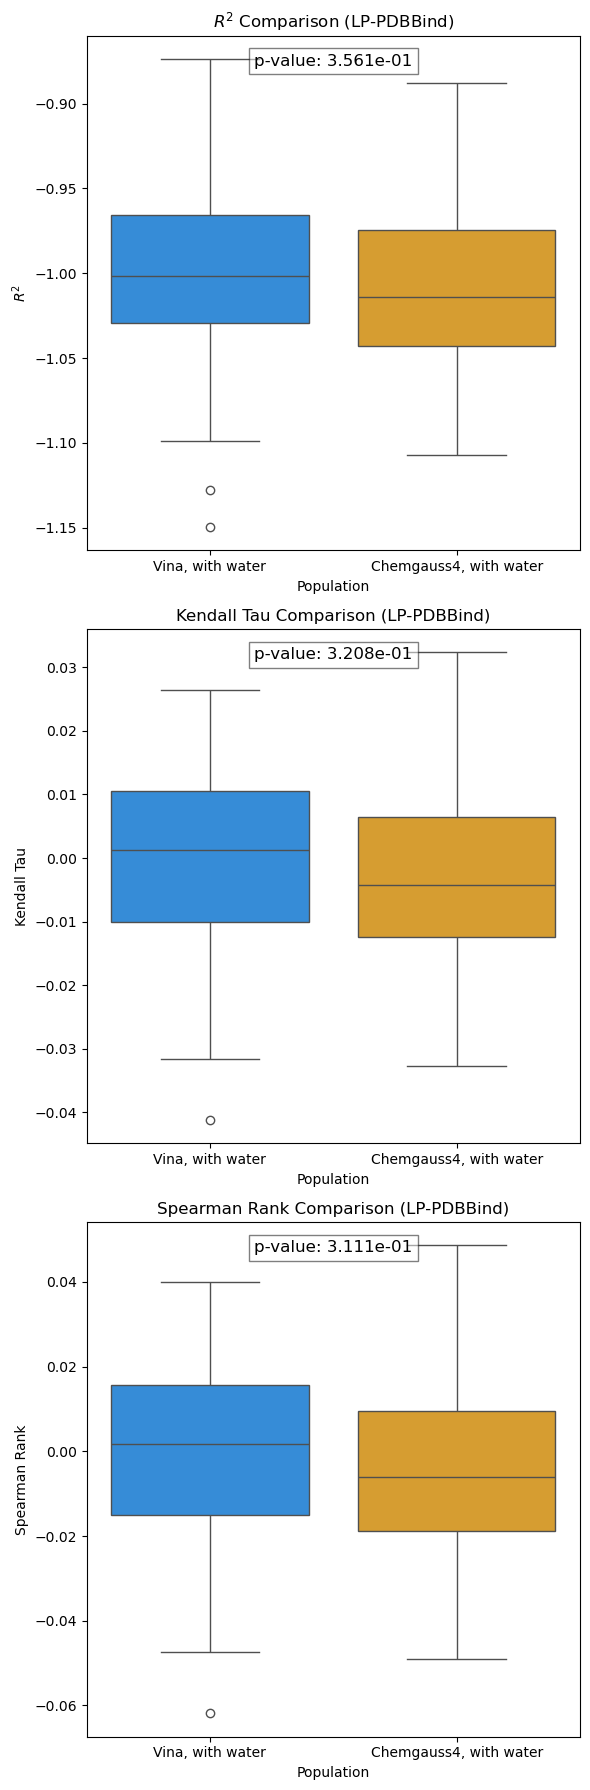

In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import kendalltau, spearmanr, mannwhitneyu, shapiro, f_oneway, ttest_ind
from sklearn.metrics import r2_score

population1 = leakypdb_test_vina_water['computed_dG']
population2 = leakypdb_test_oe_water['Chemgauss4']
n_samples= 50

# Initialize lists to store results
r2_values_pop1 = []
kendall_tau_values_pop1 = []
spearman_rank_values_pop1 = []

r2_values_pop2 = []
kendall_tau_values_pop2 = []
spearman_rank_values_pop2 = []

# Perform bootstrap sampling for population 1
for _ in range(n_samples):
    sample1 = population1.sample(frac=1, replace=True)
    
    # Compute R²
    r2 = r2_score(population1, sample1)
    r2_values_pop1.append(r2)
    
    # Compute Kendall Tau
    tau, _ = kendalltau(population1, sample1)
    kendall_tau_values_pop1.append(tau)
    
    # Compute Spearman Rank
    spearman, _ = spearmanr(population1, sample1)
    spearman_rank_values_pop1.append(spearman)

# Perform bootstrap sampling for population 2
for _ in range(n_samples):
    sample2 = population2.sample(frac=1, replace=True)
    
    # Compute R²
    r2 = r2_score(population2, sample2)
    r2_values_pop2.append(r2)
    
    # Compute Kendall Tau
    tau, _ = kendalltau(population2, sample2)
    kendall_tau_values_pop2.append(tau)
    
    # Compute Spearman Rank
    spearman, _ = spearmanr(population2, sample2)
    spearman_rank_values_pop2.append(spearman)

# Create DataFrames from the results
results_df_pop1 = pd.DataFrame({
    '$R^2$': r2_values_pop1,
    'Kendall Tau': kendall_tau_values_pop1,
    'Spearman Rank': spearman_rank_values_pop1,
    'Population': 'Vina, with water'
})

results_df_pop2 = pd.DataFrame({
    '$R^2$': r2_values_pop2,
    'Kendall Tau': kendall_tau_values_pop2,
    'Spearman Rank': spearman_rank_values_pop2,
    'Population': 'Chemgauss4, with water'
})

# Concatenate the results
results_df = pd.concat([results_df_pop1, results_df_pop2])

# Check if data is normally distributed
_, p_pop1_r2 = shapiro(r2_values_pop1)
_, p_pop2_r2 = shapiro(r2_values_pop2)
_, p_pop1_kendall = shapiro(kendall_tau_values_pop1)
_, p_pop2_kendall = shapiro(kendall_tau_values_pop2)
_, p_pop1_spearman = shapiro(spearman_rank_values_pop1)
_, p_pop2_spearman = shapiro(spearman_rank_values_pop2)

# Perform appropriate statistical tests
if p_pop1_r2 > 0.05 and p_pop2_r2 > 0.05:
    _, p_value_r2 = f_oneway(r2_values_pop1, r2_values_pop2)
else:
    _, p_value_r2 = mannwhitneyu(r2_values_pop1, r2_values_pop2)

if p_pop1_kendall > 0.05 and p_pop2_kendall > 0.05:
    _, p_value_kendall = f_oneway(kendall_tau_values_pop1, kendall_tau_values_pop2)
else:
    _, p_value_kendall = mannwhitneyu(kendall_tau_values_pop1, kendall_tau_values_pop2)

if p_pop1_spearman > 0.05 and p_pop2_spearman > 0.05:
    _, p_value_spearman = f_oneway(spearman_rank_values_pop1, spearman_rank_values_pop2)
else:
    _, p_value_spearman = mannwhitneyu(spearman_rank_values_pop1, spearman_rank_values_pop2)

# Plot R2 Comparison
fig, axes = plt.subplots(3, 1, figsize=(6, 18))

sns.boxplot(x='Population', y='$R^2$', data=results_df, ax=axes[0], palette=['#1B8EF2','#F2A516'])
axes[0].set_title('$R^2$ Comparison (LP-PDBBind)')
axes[0].text(0.5, 0.95, f'p-value: {p_value_r2:.3e}', ha='center', va='center', transform=axes[0].transAxes, fontsize=12, bbox=dict(facecolor='white', alpha=0.5))

# Plot Kendall Tau Comparison
sns.boxplot(x='Population', y='Kendall Tau', data=results_df, ax=axes[1], palette=['#1B8EF2','#F2A516'])
axes[1].set_title('Kendall Tau Comparison (LP-PDBBind)')
axes[1].text(0.5, 0.95, f'p-value: {p_value_kendall:.3e}', ha='center', va='center', transform=axes[1].transAxes, fontsize=12, bbox=dict(facecolor='white', alpha=0.5))

# Plot Spearman Rank Comparison
sns.boxplot(x='Population', y='Spearman Rank', data=results_df, ax=axes[2], palette=['#1B8EF2','#F2A516'])
axes[2].set_title('Spearman Rank Comparison (LP-PDBBind)')
axes[2].text(0.5, 0.95, f'p-value: {p_value_spearman:.3e}', ha='center', va='center', transform=axes[2].transAxes, fontsize=12, bbox=dict(facecolor='white', alpha=0.5))

plt.tight_layout()
plt.show()


/tmp/ipykernel_3536927/3060467129.py:98: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Population', y='$R^2$', data=results_df, ax=axes[0], palette=['#1B8EF2','#F2A516'])
/tmp/ipykernel_3536927/3060467129.py:103: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Population', y='Kendall Tau', data=results_df, ax=axes[1], palette=['#1B8EF2','#F2A516'])
/tmp/ipykernel_3536927/3060467129.py:108: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Population', y='Spearman Rank', data=results_df, ax=axes[2], palette=['#1B8EF2','#F2A516'])


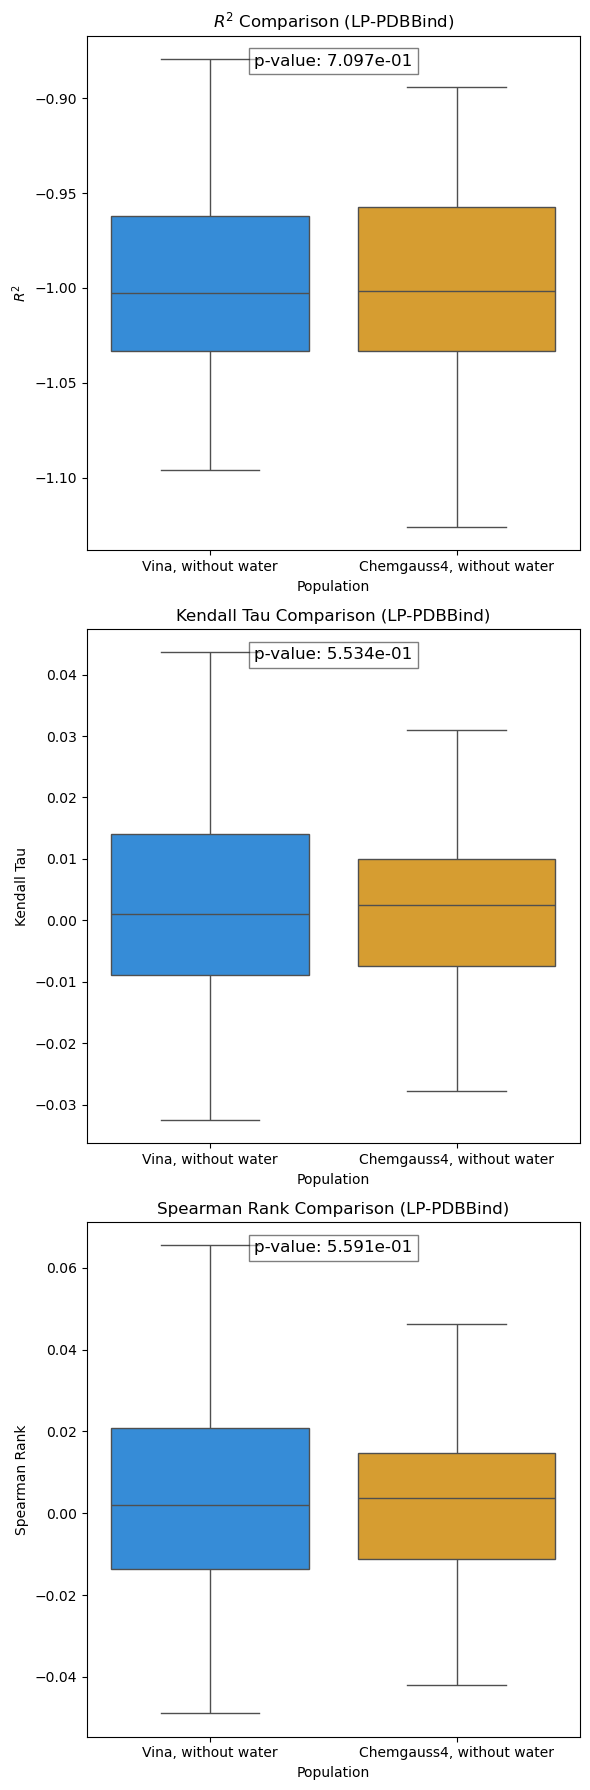

In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import kendalltau, spearmanr, mannwhitneyu, shapiro, f_oneway, ttest_ind
from sklearn.metrics import r2_score

population1 = leakypdb_test_vina['computed_dG']
population2 = leakypdb_test_oe['Chemgauss4']
n_samples= 50

# Initialize lists to store results
r2_values_pop1 = []
kendall_tau_values_pop1 = []
spearman_rank_values_pop1 = []

r2_values_pop2 = []
kendall_tau_values_pop2 = []
spearman_rank_values_pop2 = []

# Perform bootstrap sampling for population 1
for _ in range(n_samples):
    sample1 = population1.sample(frac=1, replace=True)
    
    # Compute R²
    r2 = r2_score(population1, sample1)
    r2_values_pop1.append(r2)
    
    # Compute Kendall Tau
    tau, _ = kendalltau(population1, sample1)
    kendall_tau_values_pop1.append(tau)
    
    # Compute Spearman Rank
    spearman, _ = spearmanr(population1, sample1)
    spearman_rank_values_pop1.append(spearman)

# Perform bootstrap sampling for population 2
for _ in range(n_samples):
    sample2 = population2.sample(frac=1, replace=True)
    
    # Compute R²
    r2 = r2_score(population2, sample2)
    r2_values_pop2.append(r2)
    
    # Compute Kendall Tau
    tau, _ = kendalltau(population2, sample2)
    kendall_tau_values_pop2.append(tau)
    
    # Compute Spearman Rank
    spearman, _ = spearmanr(population2, sample2)
    spearman_rank_values_pop2.append(spearman)

# Create DataFrames from the results
results_df_pop1 = pd.DataFrame({
    '$R^2$': r2_values_pop1,
    'Kendall Tau': kendall_tau_values_pop1,
    'Spearman Rank': spearman_rank_values_pop1,
    'Population': 'Vina, without water'
})

results_df_pop2 = pd.DataFrame({
    '$R^2$': r2_values_pop2,
    'Kendall Tau': kendall_tau_values_pop2,
    'Spearman Rank': spearman_rank_values_pop2,
    'Population': 'Chemgauss4, without water'
})

# Concatenate the results
results_df = pd.concat([results_df_pop1, results_df_pop2])

# Check if data is normally distributed
_, p_pop1_r2 = shapiro(r2_values_pop1)
_, p_pop2_r2 = shapiro(r2_values_pop2)
_, p_pop1_kendall = shapiro(kendall_tau_values_pop1)
_, p_pop2_kendall = shapiro(kendall_tau_values_pop2)
_, p_pop1_spearman = shapiro(spearman_rank_values_pop1)
_, p_pop2_spearman = shapiro(spearman_rank_values_pop2)

# Perform appropriate statistical tests
if p_pop1_r2 > 0.05 and p_pop2_r2 > 0.05:
    _, p_value_r2 = f_oneway(r2_values_pop1, r2_values_pop2)
else:
    _, p_value_r2 = mannwhitneyu(r2_values_pop1, r2_values_pop2)

if p_pop1_kendall > 0.05 and p_pop2_kendall > 0.05:
    _, p_value_kendall = f_oneway(kendall_tau_values_pop1, kendall_tau_values_pop2)
else:
    _, p_value_kendall = mannwhitneyu(kendall_tau_values_pop1, kendall_tau_values_pop2)

if p_pop1_spearman > 0.05 and p_pop2_spearman > 0.05:
    _, p_value_spearman = f_oneway(spearman_rank_values_pop1, spearman_rank_values_pop2)
else:
    _, p_value_spearman = mannwhitneyu(spearman_rank_values_pop1, spearman_rank_values_pop2)

# Plot R2 Comparison
fig, axes = plt.subplots(3, 1, figsize=(6, 18))

sns.boxplot(x='Population', y='$R^2$', data=results_df, ax=axes[0], palette=['#1B8EF2','#F2A516'])
axes[0].set_title('$R^2$ Comparison (LP-PDBBind)')
axes[0].text(0.5, 0.95, f'p-value: {p_value_r2:.3e}', ha='center', va='center', transform=axes[0].transAxes, fontsize=12, bbox=dict(facecolor='white', alpha=0.5))

# Plot Kendall Tau Comparison
sns.boxplot(x='Population', y='Kendall Tau', data=results_df, ax=axes[1], palette=['#1B8EF2','#F2A516'])
axes[1].set_title('Kendall Tau Comparison (LP-PDBBind)')
axes[1].text(0.5, 0.95, f'p-value: {p_value_kendall:.3e}', ha='center', va='center', transform=axes[1].transAxes, fontsize=12, bbox=dict(facecolor='white', alpha=0.5))

# Plot Spearman Rank Comparison
sns.boxplot(x='Population', y='Spearman Rank', data=results_df, ax=axes[2], palette=['#1B8EF2','#F2A516'])
axes[2].set_title('Spearman Rank Comparison (LP-PDBBind)')
axes[2].text(0.5, 0.95, f'p-value: {p_value_spearman:.3e}', ha='center', va='center', transform=axes[2].transAxes, fontsize=12, bbox=dict(facecolor='white', alpha=0.5))

plt.tight_layout()
plt.show()


/tmp/ipykernel_3536927/2836677537.py:98: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Population', y='$R^2$', data=results_df, ax=axes[0], palette=['#1B8EF2','#F2A516'])
/tmp/ipykernel_3536927/2836677537.py:103: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Population', y='Kendall Tau', data=results_df, ax=axes[1], palette=['#1B8EF2','#F2A516'])
/tmp/ipykernel_3536927/2836677537.py:108: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Population', y='Spearman Rank', data=results_df, ax=axes[2], palette=['#1B8EF2','#F2A516'])


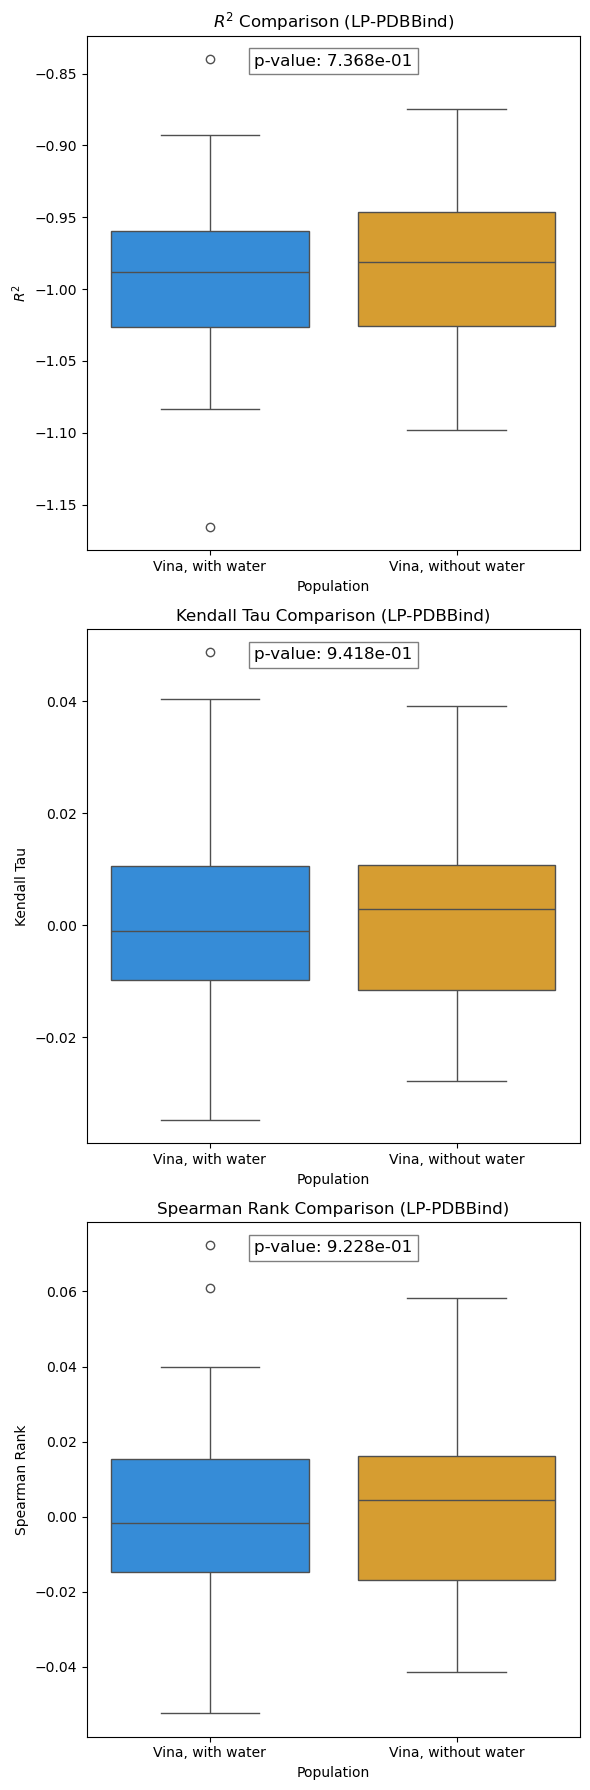

In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import kendalltau, spearmanr, mannwhitneyu, shapiro, f_oneway, ttest_ind
from sklearn.metrics import r2_score

population1 = leakypdb_test_vina_water['computed_dG']
population2 = leakypdb_test_vina['computed_dG']
n_samples= 50

# Initialize lists to store results
r2_values_pop1 = []
kendall_tau_values_pop1 = []
spearman_rank_values_pop1 = []

r2_values_pop2 = []
kendall_tau_values_pop2 = []
spearman_rank_values_pop2 = []

# Perform bootstrap sampling for population 1
for _ in range(n_samples):
    sample1 = population1.sample(frac=1, replace=True)
    
    # Compute R²
    r2 = r2_score(population1, sample1)
    r2_values_pop1.append(r2)
    
    # Compute Kendall Tau
    tau, _ = kendalltau(population1, sample1)
    kendall_tau_values_pop1.append(tau)
    
    # Compute Spearman Rank
    spearman, _ = spearmanr(population1, sample1)
    spearman_rank_values_pop1.append(spearman)

# Perform bootstrap sampling for population 2
for _ in range(n_samples):
    sample2 = population2.sample(frac=1, replace=True)
    
    # Compute R²
    r2 = r2_score(population2, sample2)
    r2_values_pop2.append(r2)
    
    # Compute Kendall Tau
    tau, _ = kendalltau(population2, sample2)
    kendall_tau_values_pop2.append(tau)
    
    # Compute Spearman Rank
    spearman, _ = spearmanr(population2, sample2)
    spearman_rank_values_pop2.append(spearman)

# Create DataFrames from the results
results_df_pop1 = pd.DataFrame({
    '$R^2$': r2_values_pop1,
    'Kendall Tau': kendall_tau_values_pop1,
    'Spearman Rank': spearman_rank_values_pop1,
    'Population': 'Vina, with water'
})

results_df_pop2 = pd.DataFrame({
    '$R^2$': r2_values_pop2,
    'Kendall Tau': kendall_tau_values_pop2,
    'Spearman Rank': spearman_rank_values_pop2,
    'Population': 'Vina, without water'
})

# Concatenate the results
results_df = pd.concat([results_df_pop1, results_df_pop2])

# Check if data is normally distributed
_, p_pop1_r2 = shapiro(r2_values_pop1)
_, p_pop2_r2 = shapiro(r2_values_pop2)
_, p_pop1_kendall = shapiro(kendall_tau_values_pop1)
_, p_pop2_kendall = shapiro(kendall_tau_values_pop2)
_, p_pop1_spearman = shapiro(spearman_rank_values_pop1)
_, p_pop2_spearman = shapiro(spearman_rank_values_pop2)

# Perform appropriate statistical tests
if p_pop1_r2 > 0.05 and p_pop2_r2 > 0.05:
    _, p_value_r2 = f_oneway(r2_values_pop1, r2_values_pop2)
else:
    _, p_value_r2 = mannwhitneyu(r2_values_pop1, r2_values_pop2)

if p_pop1_kendall > 0.05 and p_pop2_kendall > 0.05:
    _, p_value_kendall = f_oneway(kendall_tau_values_pop1, kendall_tau_values_pop2)
else:
    _, p_value_kendall = mannwhitneyu(kendall_tau_values_pop1, kendall_tau_values_pop2)

if p_pop1_spearman > 0.05 and p_pop2_spearman > 0.05:
    _, p_value_spearman = f_oneway(spearman_rank_values_pop1, spearman_rank_values_pop2)
else:
    _, p_value_spearman = mannwhitneyu(spearman_rank_values_pop1, spearman_rank_values_pop2)

# Plot R2 Comparison
fig, axes = plt.subplots(3, 1, figsize=(6, 18))

sns.boxplot(x='Population', y='$R^2$', data=results_df, ax=axes[0], palette=['#1B8EF2','#F2A516'])
axes[0].set_title('$R^2$ Comparison (LP-PDBBind)')
axes[0].text(0.5, 0.95, f'p-value: {p_value_r2:.3e}', ha='center', va='center', transform=axes[0].transAxes, fontsize=12, bbox=dict(facecolor='white', alpha=0.5))

# Plot Kendall Tau Comparison
sns.boxplot(x='Population', y='Kendall Tau', data=results_df, ax=axes[1], palette=['#1B8EF2','#F2A516'])
axes[1].set_title('Kendall Tau Comparison (LP-PDBBind)')
axes[1].text(0.5, 0.95, f'p-value: {p_value_kendall:.3e}', ha='center', va='center', transform=axes[1].transAxes, fontsize=12, bbox=dict(facecolor='white', alpha=0.5))

# Plot Spearman Rank Comparison
sns.boxplot(x='Population', y='Spearman Rank', data=results_df, ax=axes[2], palette=['#1B8EF2','#F2A516'])
axes[2].set_title('Spearman Rank Comparison (LP-PDBBind)')
axes[2].text(0.5, 0.95, f'p-value: {p_value_spearman:.3e}', ha='center', va='center', transform=axes[2].transAxes, fontsize=12, bbox=dict(facecolor='white', alpha=0.5))

plt.tight_layout()
plt.show()


### CASP16 data

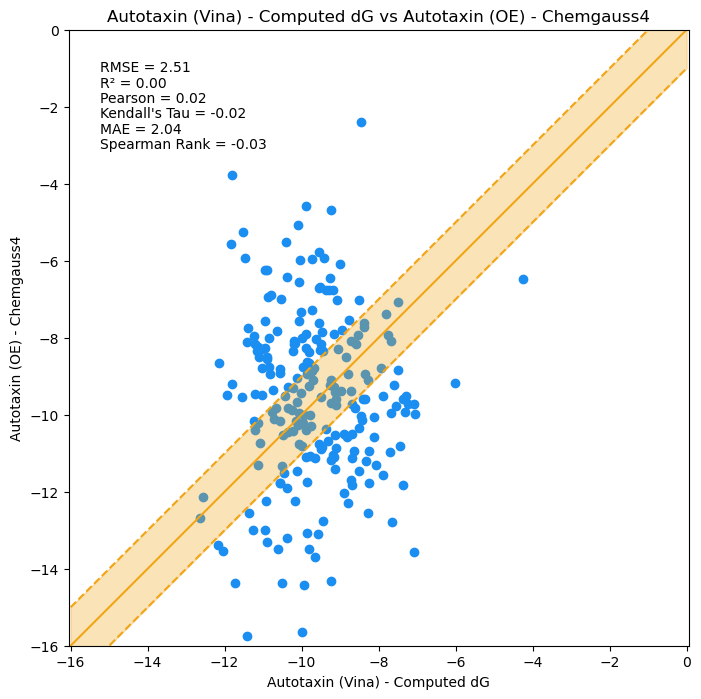

In [49]:
# Merge DataFrames
merged_df = merge_dataframes(casp16_autotaxin_vina, casp16_autotaxin_oe, key_column='ligand_name')
# Plot scatter plot using merged data
plot_scatter(merged_df['computed_dG'], merged_df['Chemgauss4'], 
             'Autotaxin (Vina) - Computed dG', 
             'Autotaxin (OE) - Chemgauss4', min_X=-16)

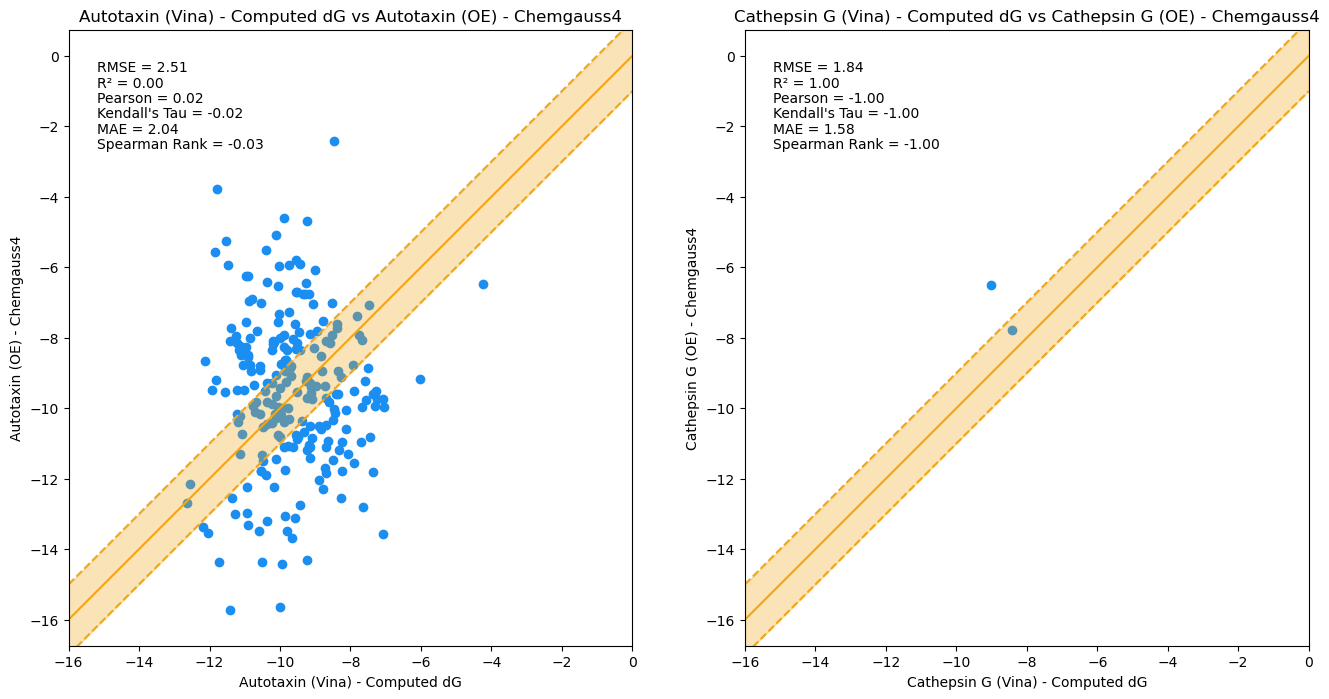

In [133]:
# Merge DataFrames
merged_df1 = merge_dataframes(casp16_autotaxin_vina, casp16_autotaxin_oe, key_column='ligand_name')
merged_df2 = merge_dataframes(casp16_cathepsin_vina, casp16_cathepsin_oe, key_column='ligand_name')
# Plot scatter plot using merged data
plot_side_by_side_scatter(merged_df1['computed_dG'], merged_df1['Chemgauss4'], 
             'Autotaxin (Vina) - Computed dG', 
             'Autotaxin (OE) - Chemgauss4',
merged_df2['computed_dG'], merged_df2['Chemgauss4'], 
             'Cathepsin G (Vina) - Computed dG', 
             'Cathepsin G (OE) - Chemgauss4', min_X=-16)

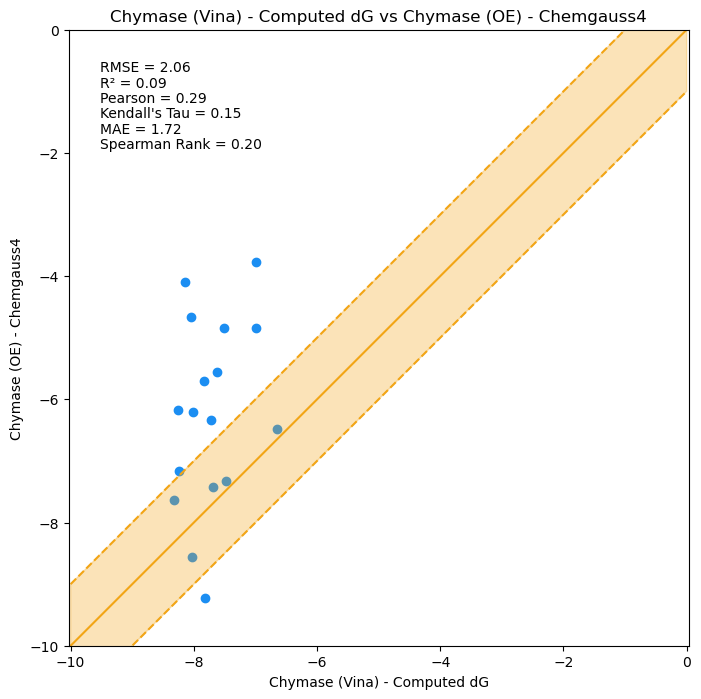

In [134]:
# Merge DataFrames
merged_df = merge_dataframes(casp16_chymase_vina, casp16_chymase_oe, key_column='ligand_name')
# Plot scatter plot using merged data
plot_scatter(merged_df['computed_dG'], merged_df['Chemgauss4'], 
             'Chymase (Vina) - Computed dG', 
             'Chymase (OE) - Chemgauss4', min_X=-10)

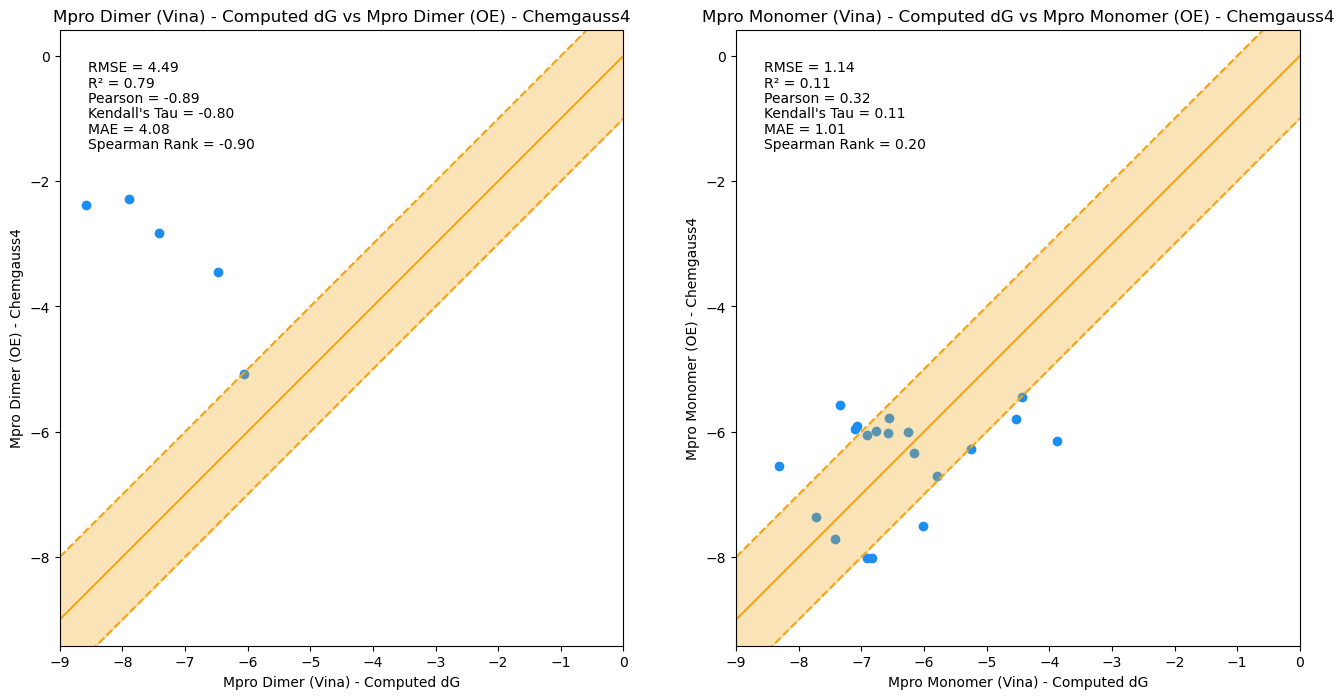

In [136]:
# Merge DataFrames
merged_df1 = merge_dataframes(casp16_mpro_dimer_vina, casp16_mpro_dimer_oe, key_column='ligand_name')
merged_df2 = merge_dataframes(casp16_mpro_monomer_vina, casp16_mpro_monomer_oe, key_column='ligand_name')
# Plot scatter plot using merged data
plot_side_by_side_scatter(merged_df1['computed_dG'], merged_df1['Chemgauss4'], 
             'Mpro Dimer (Vina) - Computed dG', 
             'Mpro Dimer (OE) - Chemgauss4',
merged_df2['computed_dG'], merged_df2['Chemgauss4'], 
             'Mpro Monomer (Vina) - Computed ΔG', 
             'Mpro Monomer (OE) - Chemgauss4', min_X=-9)

**Mean Unsigned Error (MUE) for dG: 2.44:** This is the average absolute difference between the predicted and experimental dG values. A lower MUE indicates a better model, as it means the predictions are closer to the actual values. An MUE of 2.44 means that on average, the predictions are off by 2.44 units from the actual values.

**Pearson's correlation: 0.46:** The correlation coefficient ranges from -1 to 1, where -1 indicates a perfect negative correlation, 1 indicates a perfect positive correlation, and 0 indicates no correlation.

In this case, the value of Pearson's correlation coefficient for dG is 0.46. Since the value is positive and greater than 0, it indicates a moderate positive correlation between the predicted and experimental dG values. This means that as the experimental dG values increase, the predicted dG values also tend to increase, but not perfectly so.

**Kendall Tau for dG: 0.32:** This is a measure of the rank correlation between the predicted and experimental dG values. It ranges from -1 (total disagreement in rankings) to 1 (total agreement in rankings). A value of 0.32 indicates a moderate positive correlation, meaning that as the experimental dG values increase, the predicted dG values also tend to increase, but not perfectly so.

**Root Mean Square Error (RMSE) for dG: 3.16:** This is a measure of the average magnitude of the error. It's more sensitive to large errors than MUE because it squares the differences before averaging them. An RMSE of 3.16 means that the standard deviation of the prediction errors is 3.16 units. Lower values of RMSE indicate better fit to the data.

Computing some stats to see if computed dG are the same as the exp dG

In [ ]:
# Check if data is normally distributed
_, p_comp = stats.shapiro(df['computed_dG'])
_, p_exp = stats.shapiro(df['experimental_dG'])

print(f"Computed dG shapiro p-value: {p_comp}")
print(f"Experimental dG shapiro p-value: {p_exp}")

# If p-value is > 0.05, data is normally distributed
if p_comp > 0.05 and p_exp > 0.05:
    # Perform ANOVA
    _, p_value = stats.f_oneway(df['computed_dG'], df['experimental_dG'])
    print(f"ANOVA p-value: {p_value:2f}")
    
    # Compute independent t-test
    t, p = ttest_ind(df['computed_dG'], df['experimental_dG'])

    print(f"Independent t-test p-value: {p:2f}")
else:
    # Perform Mann-Whitney U test for computed and experimental dG
    _, p_value = mannwhitneyu(df['computed_dG'], df['experimental_dG'])
    print(f"Mann-Whitney U test p-value: {p_value:2f}")

Computed dG shapiro p-value: 4.8466090643378864e-11
Experimental dG shapiro p-value: 1.3234587072000354e-10
Mann-Whitney U test p-value: 0.000000


The Shapiro-Wilk test is used to check the normality of data. A p-value less than 0.05 typically indicates that the data is not normally distributed.

1. **Computed dG shapiro p-value: 4.8e-11**: This p-value is significantly less than 0.05, indicating that the computed `dG` values are not normally distributed.

2. **Experimental dG shapiro p-value: 1.3e-10**: This p-value is also significantly less than 0.05, indicating that the experimental `dG` values are not normally distributed.

Since both sets of data are not normally distributed, the script correctly proceeds to use the Mann-Whitney U test instead of an ANOVA or independent t-test (which assume normality).

3. **Mann-Whitney U test p-value: 2.0e-78**: The Mann-Whitney U test is a nonparametric test that compares the distributions of two independent samples. A p-value less than 0.05 typically indicates a statistically significant difference between the two distributions. In this case, the p-value is extremely small, indicating a very strong evidence that the distributions of computed and experimental `dG` values are significantly different.

In summary, these results suggest that the computed and experimental `dG` values have significantly different distributions, and neither distribution is normal.

Define some functions to calculate pKi from computed dG, to convert literature Kd/Ki (from csv file provided by leakypdb) into dG, and statistics for the computed dG vs literature dG

In [ ]:
# convert computed_dG to pKi
import math

def delta_g_to_pki(dG, temperature=298):
    R = 1.987 # gas constant in cal/(mol*K)
    RT = R * temperature
    ki = math.exp(dG * 1000 / RT)  # conversion of dG from kcal/mol to cal/mol
    pki = -math.log10(ki)
    return pki
pki = delta_g_to_pki(-9.5)
pki 
# leakypdb_test_Autoock['computed_dG']

6.967769660648059

## Investigating PDB processes that produced an error

In [4]:
# find out how many PDB IDs produced an error
error_count = leakypdb_test_vina['error_message'].count()
print(f"Number of PDB IDs that produced an error: {error_count}, "
      f"which represents {error_count/len(leakypdb_test_vina)*100:.2f}% of the dataset")

Number of PDB IDs that produced an error: 773, which represents 35.61% of the dataset


In [5]:
# find out the different types of errors
error_types = leakypdb_test_vina['error_message'].value_counts()
print(error_types)

local variable 'out' referenced before assignment                                                                                                                      710
'NoneType' object has no attribute 'GetLigand'                                                                                                                          54
Command './ADFRsuite/ADFRsuite_x86_64Linux_1.0/bin/prepare_ligand -l 4O61_ligand.pdb -o 4O61_ligand.pdbqt -A hydrogens' returned non-zero exit status 1.                 1
Command './ADFRsuite/ADFRsuite_x86_64Linux_1.0/bin/prepare_receptor -r 6NFY_receptor.pdb -o 6NFY_receptor.pdbqt -A checkhydrogens' returned non-zero exit status 1.      1
Command './ADFRsuite/ADFRsuite_x86_64Linux_1.0/bin/prepare_receptor -r 3STD_receptor.pdb -o 3STD_receptor.pdbqt -A checkhydrogens' returned non-zero exit status 1.      1
Command './ADFRsuite/ADFRsuite_x86_64Linux_1.0/bin/prepare_receptor -r 4IQ6_receptor.pdb -o 4IQ6_receptor.pdbqt -A checkhydrogens' returned non-z

In [ ]:
# find out the PDB IDs that produced an error
error_pdbs = leakypdb_test_AutoDock[leakypdb_test_AutoDock['error_message'].notnull()]
error_pdbs_ids = error_pdbs['pdb_id'].tolist()

In [ ]:
# what are the pdb ids that produced the error 'NoneType' object has no attribute 'GetLigand'?
lig_ext_failure = error_pdbs[error_pdbs['error_message'].str.contains("'NoneType' object has no attribute 'GetLigand'")]
lig_ext_failure.to_csv('error_pdbs_ligandextraction_FAILURE.csv')

# Histogram for experimental results

In [34]:
mpro_vina_water

,ligand_name,ligand_smiles,protein_name,protein_sequence,computed_dG,error_message,binding_affinity,experimental_dG
1,Updated_Mpro_data_1,Brc1ccc2c(c1)C(C(=O)Nc1cncc3ccccc13)CC(=O)N2,6YNQ_receptor_fixed,SGFRKMAFPSGKVEGCMVQVTCGTTTLNGLWLDDVVYCPRHVICTS...,-6.195,NaN,5.900000,-8.048610
2,Updated_Mpro_data_2,Brc1ccc2c(c1)C(C(=O)Nc1cncc3ccccc13)CCO2,6YNQ_receptor_fixed,SGFRKMAFPSGKVEGCMVQVTCGTTTLNGLWLDDVVYCPRHVICTS...,-6.135,NaN,6.100000,-8.321444
3,Updated_Mpro_data_3,C#CC(=O)N1CCN(Cc2cccc(Cl)c2)[C@@H]2CS(=O)(=O)C...,6YNQ_receptor_fixed,SGFRKMAFPSGKVEGCMVQVTCGTTTLNGLWLDDVVYCPRHVICTS...,-5.064,NaN,5.320000,-7.257390
4,Updated_Mpro_data_4,C#Cc1ccc2c(c1)[C@@H](C(=O)Nc1cncc3ccccc13)CN(C...,6YNQ_receptor_fixed,SGFRKMAFPSGKVEGCMVQVTCGTTTLNGLWLDDVVYCPRHVICTS...,-6.501,NaN,5.130000,-6.998198
5,Updated_Mpro_data_5,C#Cc1ccc2c(c1)[C@H](C(=O)Nc1cncc3ccccc13)CN(C)...,6YNQ_receptor_fixed,SGFRKMAFPSGKVEGCMVQVTCGTTTLNGLWLDDVVYCPRHVICTS...,-5.919,NaN,4.190000,-5.715877
...,...,...,...,...,...,...,...,...
2744,Updated_Mpro_data_2744,c1ccn2cnc(c2c1)NC(=O)Cc3cccc(c3)Cl,6YNQ_receptor_fixed,SGFRKMAFPSGKVEGCMVQVTCGTTTLNGLWLDDVVYCPRHVICTS...,-5.222,NaN,7.004365,-9.555152
2745,Updated_Mpro_data_2745,c1ccnc(c1)c2c(c[nH]n2)NC(=O)c3cccc4n3ccn4,6YNQ_receptor_fixed,SGFRKMAFPSGKVEGCMVQVTCGTTTLNGLWLDDVVYCPRHVICTS...,-5.979,NaN,7.004365,-9.555152
2746,Updated_Mpro_data_2746,c1cnc(nc1Cl)C#N,6YNQ_receptor_fixed,SGFRKMAFPSGKVEGCMVQVTCGTTTLNGLWLDDVVYCPRHVICTS...,-3.851,NaN,7.004365,-9.555152
2747,Updated_Mpro_data_2747,c1cscc1CN2CCN(CC2)C(=O)CCl,6YNQ_receptor_fixed,SGFRKMAFPSGKVEGCMVQVTCGTTTLNGLWLDDVVYCPRHVICTS...,-3.903,NaN,8.944124,-12.201316


/tmp/ipykernel_3564414/958929983.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels([f'{val * 100:.1f}%' for val in y_values])


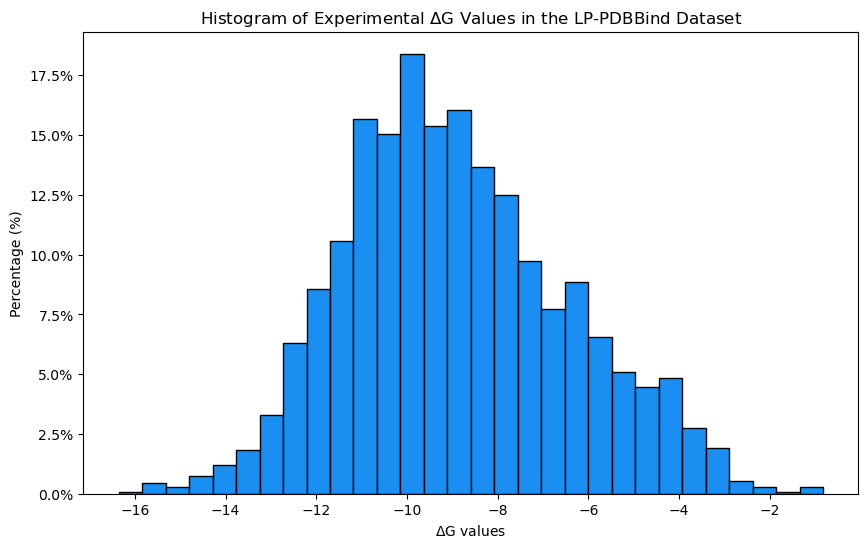

In [29]:
# Plotting the histogram
plt.figure(figsize=(10, 6))
plt.hist(leakypdb_test_oe['experimental_dG'], bins=30, edgecolor='black', density=True,color='#1B8EF2')
plt.xlabel(r'$\Delta$G values')
plt.ylabel('Percentage (%)')
plt.title(r'Histogram of Experimental $\Delta$G Values in the LP-PDBBind Dataset')

# Convert to percentage
y_values = plt.gca().get_yticks()
plt.gca().set_yticklabels([f'{val * 100:.1f}%' for val in y_values])

plt.show()

/tmp/ipykernel_3564414/999583804.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_yticklabels([f'{val * 100:.1f}%' for val in y_values1])
/tmp/ipykernel_3564414/999583804.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_yticklabels([f'{val * 100:.1f}%' for val in y_values2])


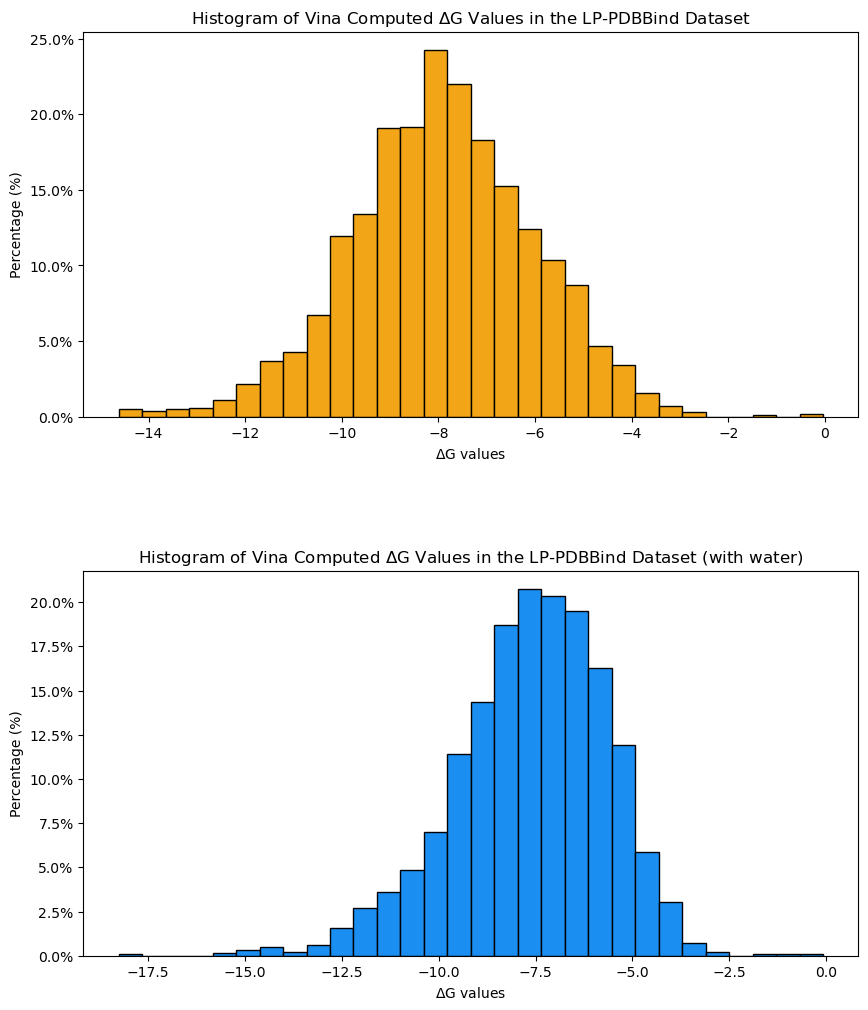

In [44]:
# Create a figure and two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12))

# Plot the histogram of Vina Computed dG values in the LP-PDBBind Dataset
ax1.hist(leakypdb_test_vina['computed_dG'], bins=30, edgecolor='black', density=True, color='#F2A516')
ax1.set_xlabel(r'$\Delta$G values')
ax1.set_ylabel('Percentage (%)')
ax1.set_title(r'Histogram of Vina Computed $\Delta$G Values in the LP-PDBBind Dataset')

# Convert y-axis tick labels to percentage
y_values1 = ax1.get_yticks()
ax1.set_yticklabels([f'{val * 100:.1f}%' for val in y_values1])

# Plot the histogram of Vina Computed dG values in the LP-PDBBind Dataset (with water)
ax2.hist(leakypdb_test_vina_water['computed_dG'], bins=30, edgecolor='black', density=True, color='#1B8EF2')
ax2.set_xlabel(r'$\Delta$G values')
ax2.set_ylabel('Percentage (%)')
ax2.set_title(r'Histogram of Vina Computed $\Delta$G Values in the LP-PDBBind Dataset (with water)')

# Convert y-axis tick labels to percentage
y_values2 = ax2.get_yticks()
ax2.set_yticklabels([f'{val * 100:.1f}%' for val in y_values2])

# Adjust spacing between subplots
plt.subplots_adjust(hspace=0.4)

# Display the plot
plt.show()

/tmp/ipykernel_3564414/1653908033.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_yticklabels([f'{val * 100:.1f}%' for val in y_values1])
/tmp/ipykernel_3564414/1653908033.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_yticklabels([f'{val * 100:.1f}%' for val in y_values2])


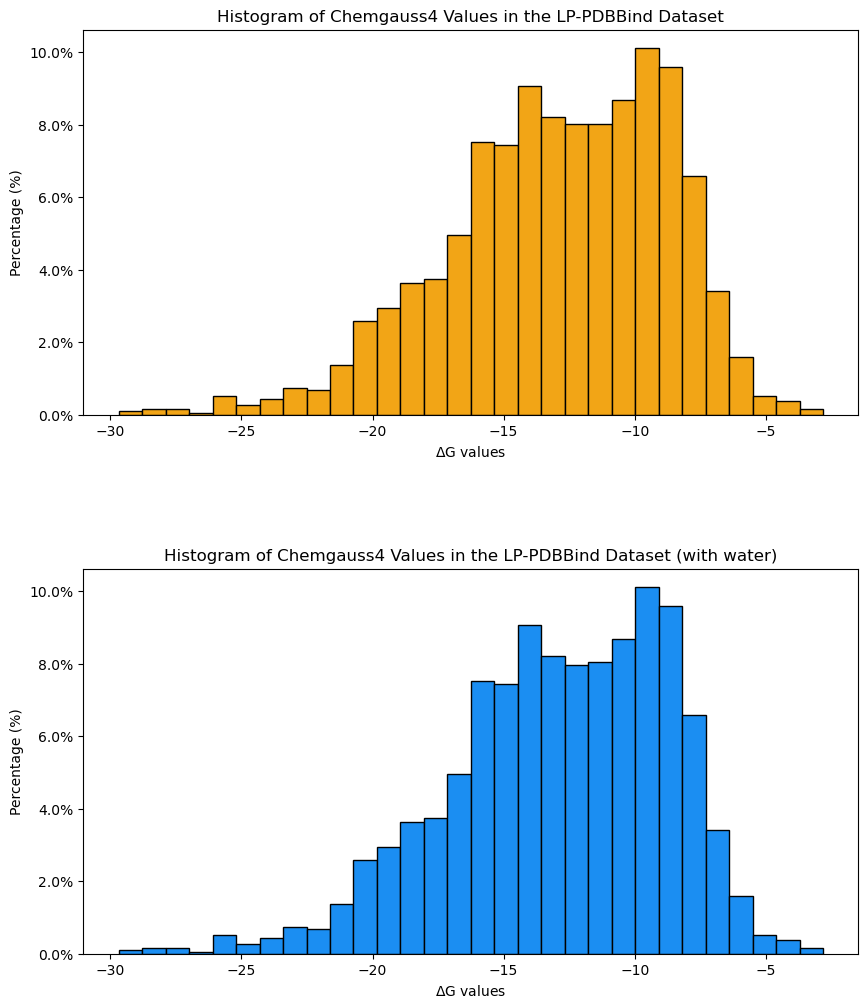

In [45]:
# Create a figure and two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12))

# Plot the histogram of Vina Computed dG values in the LP-PDBBind Dataset
ax1.hist(leakypdb_test_oe['Chemgauss4'], bins=30, edgecolor='black', density=True, color='#F2A516')
ax1.set_xlabel(r'$\Delta$G values')
ax1.set_ylabel('Percentage (%)')
ax1.set_title(r'Histogram of Chemgauss4 Values in the LP-PDBBind Dataset')

# Convert y-axis tick labels to percentage
y_values1 = ax1.get_yticks()
ax1.set_yticklabels([f'{val * 100:.1f}%' for val in y_values1])

# Plot the histogram of Vina Computed dG values in the LP-PDBBind Dataset (with water)
ax2.hist(leakypdb_test_oe_water['Chemgauss4'], bins=30, edgecolor='black', density=True, color='#1B8EF2')
ax2.set_xlabel(r'$\Delta$G values')
ax2.set_ylabel('Percentage (%)')
ax2.set_title(r'Histogram of Chemgauss4 Values in the LP-PDBBind Dataset (with water)')

# Convert y-axis tick labels to percentage
y_values2 = ax2.get_yticks()
ax2.set_yticklabels([f'{val * 100:.1f}%' for val in y_values2])

# Adjust spacing between subplots
plt.subplots_adjust(hspace=0.4)

# Display the plot
plt.show()

/tmp/ipykernel_3564414/748201984.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels([f'{val * 100:.1f}%' for val in y_values])


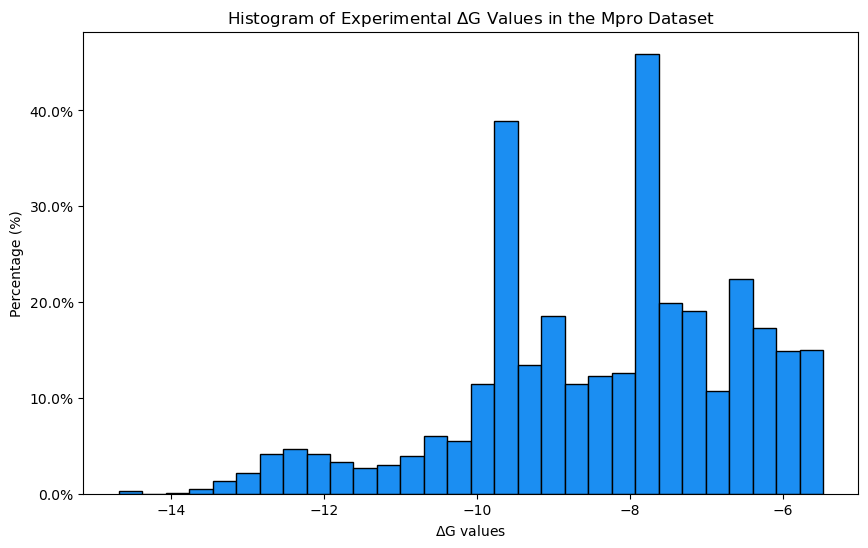

In [31]:
# Plotting the histogram
plt.figure(figsize=(10, 6))
plt.hist(mpro_vina_water['experimental_dG'], bins=30, edgecolor='black', density=True,color='#1B8EF2')
plt.xlabel(r'$\Delta$G values')
plt.ylabel('Percentage (%)')
plt.title(r'Histogram of Experimental $\Delta$G Values in the Mpro Dataset')

# Convert to percentage
y_values = plt.gca().get_yticks()
plt.gca().set_yticklabels([f'{val * 100:.1f}%' for val in y_values])

plt.show()

/tmp/ipykernel_3564414/2823510130.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_yticklabels([f'{val * 100:.1f}%' for val in y_values1])
/tmp/ipykernel_3564414/2823510130.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_yticklabels([f'{val * 100:.1f}%' for val in y_values2])


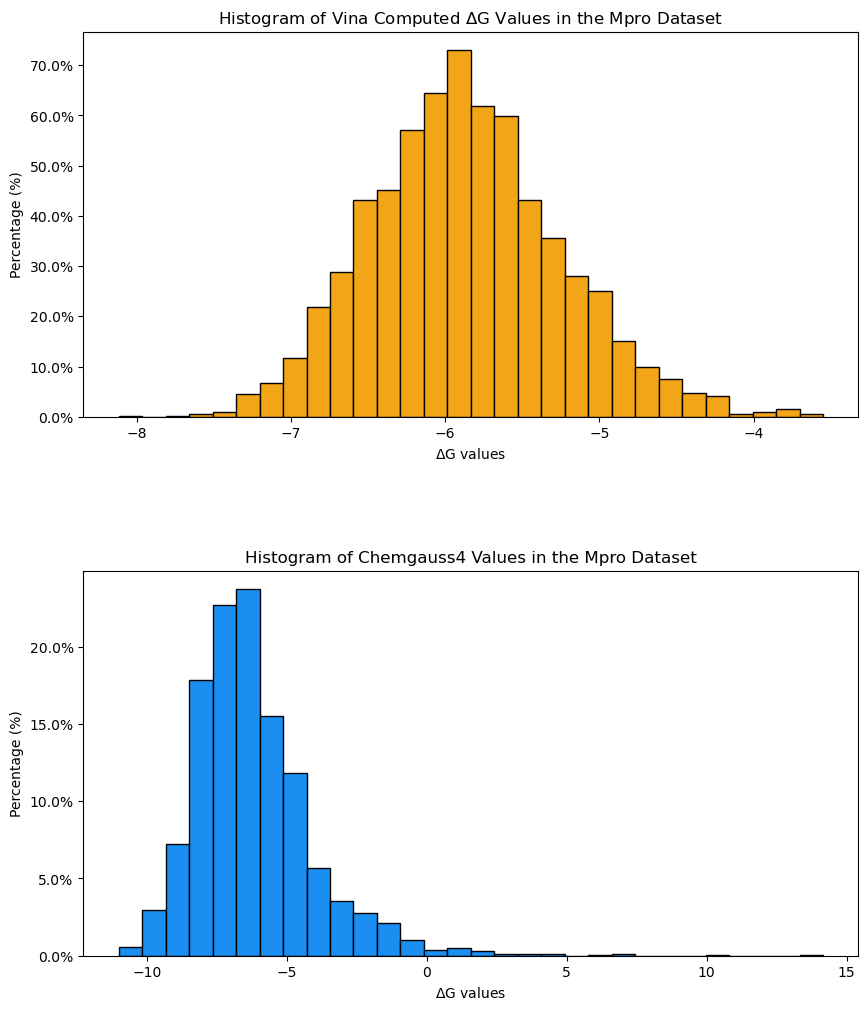

In [48]:
# Create a figure and two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12))

# Plot the histogram of Vina Computed dG values in the LP-PDBBind Dataset
ax1.hist(mpro_vina_water['computed_dG'], bins=30, edgecolor='black', density=True, color='#F2A516')
ax1.set_xlabel(r'$\Delta$G values')
ax1.set_ylabel('Percentage (%)')
ax1.set_title(r'Histogram of Vina Computed $\Delta$G Values in the Mpro Dataset')

# Convert y-axis tick labels to percentage
y_values1 = ax1.get_yticks()
ax1.set_yticklabels([f'{val * 100:.1f}%' for val in y_values1])

# Plot the histogram of Vina Computed dG values in the LP-PDBBind Dataset (with water)
ax2.hist(mpro_oe_water['Chemgauss4'], bins=30, edgecolor='black', density=True, color='#1B8EF2')
ax2.set_xlabel(r'$\Delta$G values')
ax2.set_ylabel('Percentage (%)')
ax2.set_title(r'Histogram of Chemgauss4 Values in the Mpro Dataset')

# Convert y-axis tick labels to percentage
y_values2 = ax2.get_yticks()
ax2.set_yticklabels([f'{val * 100:.1f}%' for val in y_values2])

# Adjust spacing between subplots
plt.subplots_adjust(hspace=0.4)

# Display the plot
plt.show()

/tmp/ipykernel_3564414/940340102.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels([f'{val * 100:.1f}%' for val in y_values])


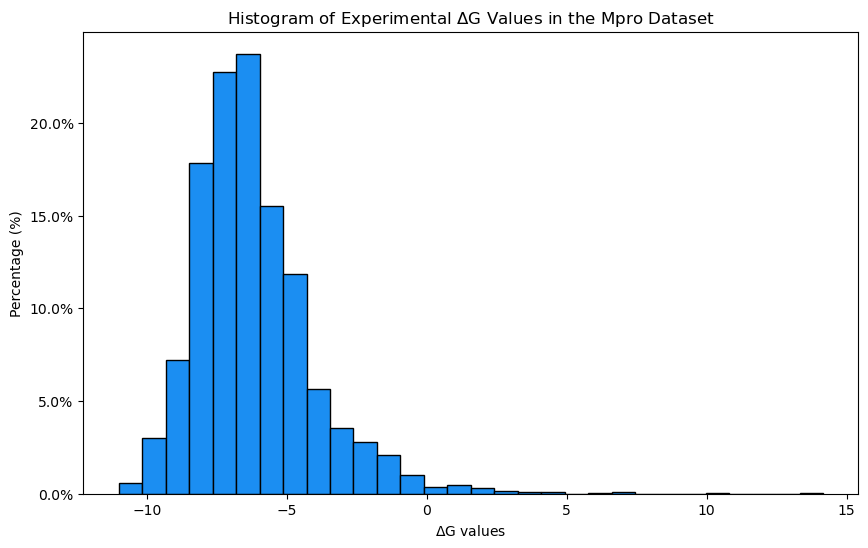

In [37]:
# Plotting the histogram
plt.figure(figsize=(10, 6))
plt.hist(mpro_oe_water['Chemgauss4'], bins=30, edgecolor='black', density=True,color='#1B8EF2')
plt.xlabel(r'$\Delta$G values')
plt.ylabel('Percentage (%)')
plt.title(r'Histogram of Experimental $\Delta$G Values in the Mpro Dataset')

# Convert to percentage
y_values = plt.gca().get_yticks()
plt.gca().set_yticklabels([f'{val * 100:.1f}%' for val in y_values])

plt.show()